# Bark Beetles: Predicting the Plague - Exploratory Data Analysis

#### Modeling the spruce bark beetle infestation in short-time intervals for locally distinct spatial administrative units within Saxony on the basis of the infestation development and the weather pattern up to the time of forecast

**by**
Yannic Holländer

**Abstract**
In this notebook the Exploratory Data Analysis (EDA) takes place. Describing relationships between different (target/explanatory) variables enables a deeper understanding of the underlying processes of the infestation development and sets expectations for feature selection as well as performance.

# 1 Setup

In [63]:
# import modules 
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import plotnine as p9

from sklearn.preprocessing import minmax_scale

# settings
warnings.filterwarnings('ignore')
# diplay all columns of a dataframe
pd.options.display.max_columns= None

# set default font (used in p9.theme_seaborn())
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Raleway']

# make custom plotnine themes
mytheme = (p9.theme_seaborn() 
           + p9.theme(
               rect = p9.element_rect(fill = (0,0,0,0), color=(0,0,0,0)), 
               panel_background=p9.element_rect(fill='#eaeaf2', alpha=.8),
               strip_text=p9.element_text(size=14),
               legend_text_legend=p9.element_text(size=14),
               text=p9.element_text(size=17),
               figure_size = (10, 7.5),
               subplots_adjust={'hspace': 0.31}
             )
            )

mythemewide = (p9.theme_seaborn() 
             + p9.theme(
                 rect = p9.element_rect(fill = (0,0,0,0), color=(0,0,0,0)), 
                 panel_background=p9.element_rect(fill='#eaeaf2', alpha=.8),
                 strip_text=p9.element_text(size=14),
                 legend_text_legend=p9.element_text(size=14),
                 text= p9.element_text(size=17),
                 figure_size = (15, 7.5), 
                 subplots_adjust={'hspace': 0.31}
             )
            )

# defining custom colors, used whenever possible to match presentation
mycolors = ['#447672', '#8fc0e0', '#ee6d71', '#ffb947', 
            '#4e445f', '#d1d882', '#9D7558', '#a7d8d4', 
            '#b0b7bd', '#ffaeac', '#f4b589', '#bfb4d2', 
            '#5b83a8', '#575757']


In [3]:
# load the dataset
data = pd.read_csv('barkbeetle_dataset.csv')

# reestablish timestamps
data['timestamp'] = pd.to_datetime(data['timestamp'])

# 2 Infestation Overview

## 2.1 Description of features
As a reminder, the following features are included in the data:

**General features:** 
* **year** - Year of the observation. Ranges from 2005 until 2020. Target variable observations range from 2006 until September 2020. Meteorological data exists from 2005 until February 2020. The year 2005 provides complementary knwoledge of weather before the start of target variable observations. Last meteorological features from February 2020, as latest climate data was not available at time of writing.
* **timeframe** - The timeframe of the observation within the year. The data is gathered monthly from April till September and quarterly from October till March. A timestamp of the last timeframe day is also included in the 'timestamp* column.
* **timestamp** - A timestamp in datetime format with the date of the observation (the last day of the timeframe). Can be used to plot the data as a time series or to do date based calculations with the data that would not be possible with the timeframe column as is.
* **forest_ownership** - A binary categorial variable that distinguishes between state owned forest (SW) and private/corporate forest (NSW)
* **id** - A unique identifier for every combination of county, forestry district and forest ownership. Every id has exactly one observation for each timestamp from 2006 until September 2020. Used to group the data. 


**Infestation related features:**
* **infested_wood** - Target variable. The amount of accumulated infested wood (in solid cubic metres). 
* **disposed_wood** - Amount of infested wood that was disposed (in solid cubic metres), i.e. the infested trees that were cut down and removed. 
* **prev_infested_wood** - Amount of infested wood for the last observation of this forestry district and ownership group (in solid cubic metres).
* **prev_disposed_wood** - Amount of disposed infested wood for the last observation of this forestry district and ownership group (in solid cubic metres).
* **prev_infested_wood_ofo** - Amount of infested wood in the last observation of this forestry district for the other ownership group (in solid cubic metres).
* **prev_infested_wood_rollyr** - Total amount of infested wood accumulated during the last 12 months in this forestry district and ownership group (in solid cubic metres)
* **prev_disposed_wood_rollyr** - Total amount of disposed infested wood accumulated during the last 12 months in this forestry district and ownership group (in solid cubic metres)
* **disposing_rate_infested_yr** - The ratio of disposed infestation wood vs accumulated infestation wood for the last 12 months. If there was no reported infested wood, or there was more wood disposed than accumulated, then the disposing rate is defined as 1.

**Forestry district related features:**
* **fdist_id** - Unique identifier for the forestry district. Has four digits. The first two digits are made up of an internal county number and the last two are made up of the number the forestry district has in this county.
* **county_name** - Name of the county the forestry distict belongs to. There are 13 counties in Saxony
* **fdist_name** - The (unique) name of the forestry distrct. There are currently 53 forestry districts in Saxony. 
* **fdist_newname** - Some forestry districts were restructured in the observation period. In case the name or border of a district did change, this denotes the current name that best approximates this district, so we can bild a consistent timeline for every district.
* **area_nse** - Forest area (in ha) that is not state owned (private/corporate forest) and endangered by the spruce bark beetle. Endangered forest is forest with a spruce ratio > 10% and a tree height >= 20 m.
* **area_nsne** - Forest area (in ha) that is not state owned (private/corporate forest) and not endangered by the spruce bark beetle.
* **area_se** - Forest area (in ha) that is state owned and endangered by the spruce bark beetle. Endangered forest is forest with a spruce ratio > 10% and a tree height >= 20 m.
* **area_sne** - Forest area (in ha) that is state owned (private/corporate forest) and not endangered by the spruce bark beetle.
* **centroid_xcoord** - X-coordinate of the forestry district centroid, representing the centre location of the forestry district. In combination with centroid_ycoord, can be used to account for the geography of Saxony without specifying 53 dummy variables for every forestry district. 
* **centroid_ycoord** - Y-coordinate of the forestry district centroid, representing the centre location of the forestry district. In combination with centroid_ycoord, can be used to account for the geography of Saxony without specifying 53 dummy variables for every forestry district. 
* **area_fdist** - The area of the forestry district, in square kilometres.
* **enangered_forest_density** - The density of endangered forest (in relation the the forestry district area).  
* **area_endangered** - Matches 'area_nse' if observation is from non-state forest and 'area_se' if observation id from state-owned forest.

**Meteorological features (for respective timeframe in respective forestry district):**
* **TX0** - mean of the daily maximum temperatures in °C
* **TM0** - mean temperature in °C
* **TN0** - mean of the daily minimum temperatures in °C
* **RF0** - mean relative humidity in %
* **SD0** - total sunshinde duration in h
* **RRU** - total precipitation in mm
* **RRK** - corrected total precipitation in mm (corrects systematic errors of the measuring device and installation location such as wetting/evaporation losses)
* **FF1** - mean of the daily mean wind velocity 10 metres above ground in m*s-1
* **FF2** - mean of the daily mean wind velocity 2 metres above ground in m*s-1
* **FFB** - mean of the daily wind speed of the day on the beaufort scale in bft
* **RGK** - total global irridiation in kWh*m-2
* **ETP** - potential evaporation in mm
* **GRV** - potential evapotranspiration in mm
* **KWU** - waterbalance in mm
* **KWK** - corrected waterbalance in mm (corrects systematic errors of the measuring device and installation location such as wetting/evaporation losses)
* ***_rollsr** - Any of the above combined with '_rollsr' denotes the rolling mean of this parameter in this forestry district for the last six summer months (= the last year, excluding all months from October-March) 
* ***_rollwr** - Any of the above combined with '_rollwr' denotes the rolling mean of this parameter in this forestry district for the last six winter months (= the last year, excluding all months from April-September) 

**Windfall/demolition wood:**
* **demolition_wood** - Last reported amount of accumulated wood caused by abiotic damages (in solid cubic metres, reported every year in April and September).
* **disposed_demolition_wood** - The amount of demolition wood removed in the last demolition report (in solid cubic metres).
* **disposing_rate_demolition** - The ratio of disposed demolition wood to accumulated demolition wood in the last report. If there was no reported demolition wood, or there was more wood disposed than accumulated, then the disposing rate is defined as 1.

Not all of these features will be used in model building. One goal of the EDA is to ascertain important realationships as well as redundant features. 

First, examine some statistics of these features. 

In [4]:
data.describe().round(2)

,fdist_id,year,infested_wood,disposed_wood,area_nse,area_nsne,area_se,area_sne,centroid_xcoord,centroid_ycoord,area_fdist,endangered_forest_density,TX0,TM0,TN0,RF0,SD0,RRU,RRK,FF1,FF2,FFB,RGK,ETP,GRV,KWU,KWK,prev_disposed_wood,prev_infested_wood,prev_infested_wood_ofo,prev_infested_wood_rollyr,prev_disposed_wood_rollyr,TX0_rollsr,TM0_rollsr,TN0_rollsr,RF0_rollsr,SD0_rollsr,RRU_rollsr,RRK_rollsr,FF1_rollsr,FF2_rollsr,FFB_rollsr,RGK_rollsr,ETP_rollsr,GRV_rollsr,KWU_rollsr,KWK_rollsr,TX0_rollwr,TM0_rollwr,TN0_rollwr,RF0_rollwr,SD0_rollwr,RRU_rollwr,RRK_rollwr,FF1_rollwr,FF2_rollwr,FFB_rollwr,RGK_rollwr,ETP_rollwr,GRV_rollwr,KWU_rollwr,KWK_rollwr,area_endangered,demolition_wood,disposed_demolition_wood,disposing_rate_demolition,disposing_rate_infested_yr
count,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,13376.00,13376.00,13376.00,12620.00,12620.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,13484.00,13374.00,13374.00,13374.00,12620.00
mean,2408.01,2012.44,333.46,228.39,1193.25,4285.47,1755.62,2577.67,388573.97,5651744.90,347.54,1077.71,16.87,11.95,6.94,74.75,217.55,93.30,103.07,3.40,2.49,2.48,128.20,85.32,80.98,7.97,17.75,212.67,317.85,317.85,2187.49,1449.69,20.39,14.90,9.31,72.10,206.81,70.44,76.19,3.16,2.31,2.37,130.81,90.36,88.34,-19.92,-14.16,2.20,1.12,0.02,27.64,83.83,53.95,61.17,1.36,1.00,0.94,40.67,23.84,19.92,30.10,37.32,1474.43,1839.51,888.51,0.79,0.82
std,420.09,4.58,2447.14,1445.03,1095.22,2506.54,2643.74,2481.59,58410.74,37114.84,179.39,1286.34,7.17,6.14,5.20,7.18,56.44,60.30,67.51,0.73,0.54,0.35,27.01,21.80,25.77,70.50,77.72,1386.56,2377.68,2377.68,13125.97,6712.46,1.63,1.26,0.93,3.50,20.15,19.98,20.97,0.45,0.33,0.22,7.16,6.22,8.23,24.75,25.78,0.61,0.55,0.51,0.87,13.67,13.48,15.39,0.21,0.15,0.09,3.61,2.47,3.26,14.84,16.75,2042.92,8648.03,4122.46,0.30,0.28
min,1101.00,2005.00,0.00,0.00,0.00,1095.90,0.00,5.58,291131.34,5576753.53,125.18,0.00,-0.99,-3.38,-6.54,52.62,68.53,0.15,0.32,1.66,1.25,1.54,53.74,31.52,26.35,-147.90,-147.04,0.00,0.00,0.00,0.00,0.00,15.73,11.53,6.62,60.69,160.45,21.36,23.67,2.12,1.56,1.80,114.03,74.67,67.67,-86.09,-83.78,0.57,-0.40,-1.51,25.57,49.21,21.63,25.31,0.88,0.64,0.69,25.45,16.09,11.60,-6.07,-2.59,0.00,0.00,0.00,0.00,0.00
25%,2202.00,2008.00,0.00,0.00,173.07,2324.07,24.17,568.67,340650.38,5620665.56,233.58,94.79,10.76,6.98,2.75,69.22,183.81,45.03,49.56,2.88,2.11,2.23,106.71,67.85,59.41,-42.80,-37.97,0.00,0.00,0.00,0.00,0.00,19.39,14.08,8.65,70.20,192.84,56.84,62.09,2.89,2.12,2.23,125.92,86.17,82.83,-35.43,-30.28,1.75,0.72,-0.36,27.02,72.54,44.89,50.83,1.23,0.90,0.88,37.97,21.90,17.51,20.46,26.39,82.46,0.00,0.00,0.61,0.76
50%,2503.00,2012.00,0.93,0.00,1028.08,3328.44,483.53,1973.92,383811.53,5657903.85,272.44,518.09,18.68,13.38,7.99,74.63,216.33,80.71,88.21,3.28,2.41,2.44,132.74,83.93,78.73,-7.88,-0.96,0.00,0.62,0.62,99.63,75.00,20.58,15.10,9.46,72.38,204.98,68.88,74.71,3.09,2.27,2.34,130.08,89.88,88.08,-20.53,-14.70,2.17,1.12,0.05,27.64,83.45,52.29,59.03,1.33,0.98,0.93,40.57,23.90,19.63,28.67,35.60,774.06,22.00,10.00,1.00,0.98
75%,2701.00,2016.00,40.00,30.00,2062.88,6175.26,2690.42,4084.94,440710.42,5685196.85,420.64,1535.55,22.47,16.92,11.40,80.27,255.99,127.87,140.46,3.79,2.78,2.70,146.87,101.50,100.80,51.48,64.79,28.00,38.00,38.00,613.66,505.00,21.46,15.74,10.00,74.51,218.39,81.47,87.88,3.36,2.47,2.48,134.87,93.97,92.91,-5.55,0.97,2.66,1.52,0.43,28.21,93.50,62.19,70.36,1.47,1.07,0.99,43.22,25.91,22.31,39.15,47.53,2152.93,395.00,203.00,1.00,1.00
max,3003.00,2020.00,114300.00,66600.00,3922.55,10411.38,15177.90,11862.90,489264.86,5712969.85,980.54,5632.63,31.17,23.46,16.07,9

## 2.2 Map of infestation summary
To get an overview of the infestation history in Saxony, plot a map with the total number of accumulated infested wood over the whole observation period. 

Create a chloropleth map in which the total amount of obsereved infested wood (all observations) is shaded in for every forestry district. Since there is a different area of endangered forest (endangered = tree height above 20 metres as well as a spruce tree ratio of 10%) in every forestry district, we also overlay a bubble map where the bubble size represents the total area of endangered forest.

In [35]:
# define function to truncate colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    '''
    This function truncates a matlotlib colormap.
    
    inputs:
        - cmap: the colormap
        - minval: the truncation interval minimum
        - maxval: the truncation interval maximum
        - n: if n == -1 invert colormap before truncation
        
    returns:
        - the trunctated colormap
    '''
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(
             name=cmap.name, 
             a=minval, 
             b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

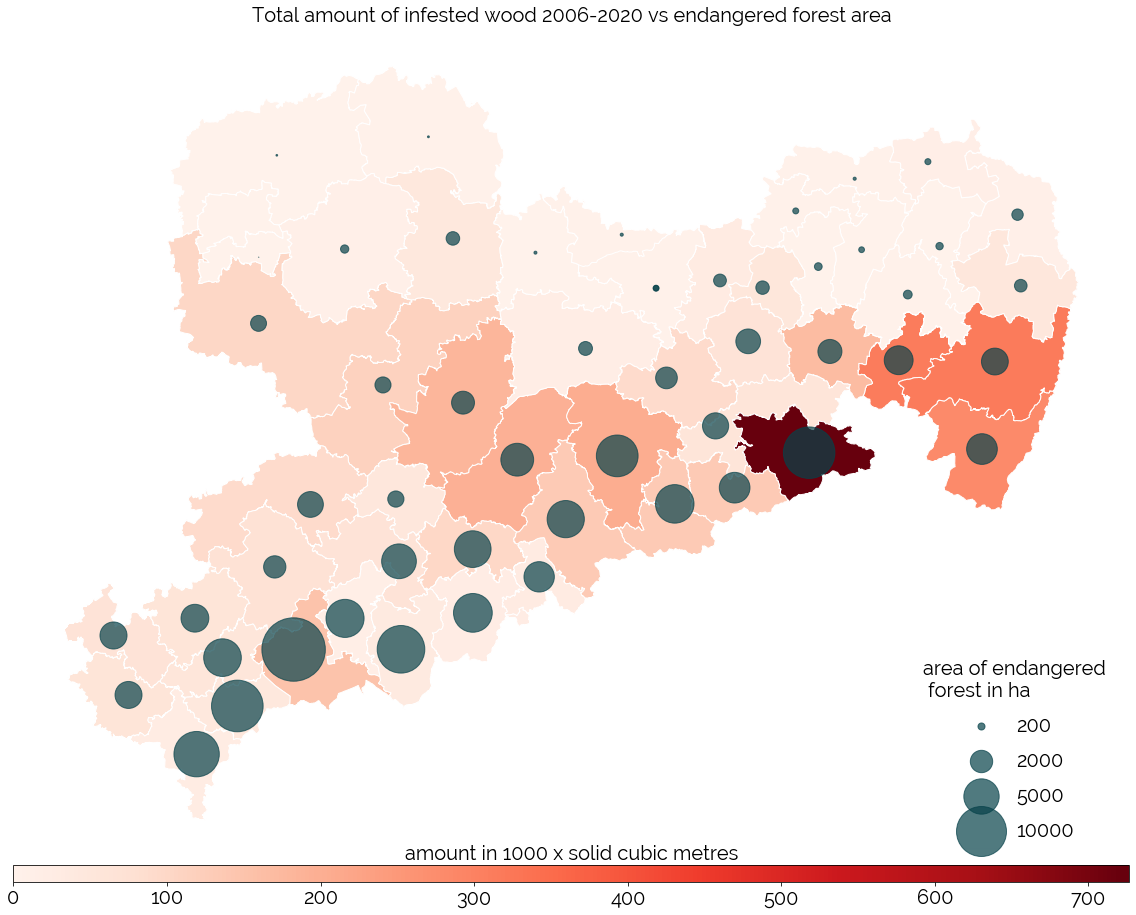

In [42]:
# plot a chloropleth map for the total observations of infested wood in 
# the forestry districts plus a bubble map for the endangered forest area

# read shapefile with geodata (geometry needed for map, not in dataset)
# we first 53 rows are needed since these are the current districts
districts_gdf = gpd.read_file(
    r'forestry_districts.shp', 
    encoding='utf-8'
).loc[:53]

# name columns according to first notebook
districts_gdf.columns = [
    'county_name', 'fdist_name', 'fdist_id', 'area_nse', 'area_nsne', 
    'area_se', 'area_sne', 'area_fdist', 'endangered_forest_density', 
    'centroid_xcoord', 'centroid_ycoord', 'geometry'
]

# get the total amount of damaged wood for every forestry district
total_infested_wood = data.groupby('fdist_name')['infested_wood'].sum()

# make this information on total amount of damaged wood a column 
# in the geodataframe 
districts_gdf['total_infested_wood'] = [
    total_infested_wood.loc[
        total_infested_wood.index == district_name
    ].item()/1000 for district_name in districts_gdf['fdist_name']
]

# create column with total amount of endangered forest area 
# (add private and state owned together)
# scale by a factor to get the nice bubble sizes, 
# later scale the same amount in legend
area_scale = .25
districts_gdf['area_endangered'] = (
    districts_gdf['area_nse'] + districts_gdf['area_se']
) * area_scale

# create figure
fig, ax = plt.subplots(figsize=(20,20))

# plot title
plt.title(
    'Total amount of infested wood 2006-2020 vs endangered forest area', 
    fontdict={'fontsize': 20}
)

# custom legend for colormap requires locateable axis
divider = make_axes_locatable(ax)
cax = divider.append_axes(
    # colormap parameters
    "bottom", size="2%", pad=0.1 
) 

# plot the forestry districts chloropleth map
districts_gdf.plot(
    ax=ax, column='total_infested_wood', 
    legend=True, cax=cax, legend_kwds={'orientation': 'horizontal'},
    edgecolor='white', linewidth=1,
    cmap=truncate_colormap(plt.get_cmap('Reds'), 0.02, 1)
)

# colormap legend title and tick fontsize
plt.title(
    'amount in 1000 x solid cubic metres', 
    fontdict={'fontsize': 20}
)
cax.tick_params(labelsize=20)

# add bubble map 
# calculate representative points from polygons (used as bubble location)
gdf_points = districts_gdf.copy()
gdf_points['geometry'] = gdf_points['geometry'].representative_point()

# plot bubbles
gdf_points.plot(
    ax=ax, 
    color='#07424A', 
    markersize='area_endangered', 
    alpha=.7, 
    categorical=False, 
    legend=True
)

# make some dummy points at 0,0 
# to use as custom handles in bubble plot legend
ax.scatter([0], [0], c='#07424A', alpha=.7, s=200*area_scale,
            label='200')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=2000*area_scale,
            label='2000')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=5000*area_scale,
            label='5000')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=10000*area_scale,
            label='10000')

# add bubble map legend
ax.legend(
    scatterpoints=1, 
    frameon=True,
    labelspacing=.8, 
    loc='lower right', 
    fontsize=20, 
    edgecolor='white',
    bbox_to_anchor=(1,0), 
    title_fontsize=20, 
    title='area of endangered \n forest in ha'
);

# x and y axis settings
ax.set_xlim(267100.4013500002, 514160.39804999967);
ax.set_ylim(5552730.938154999, 5736554.970745001);
ax.axis('off');

To get better understanding of these amounts, show the top and bottom values to complement the plot:

In [43]:
# first restore the original amount of damaged wood and 
# endangered forest area (revert any scaling)
districts_gdf['area_endangered'] = districts_gdf[
    'area_endangered'
] / area_scale

districts_gdf['total_infested_wood'] = districts_gdf[
    'total_infested_wood'
] * 1000

# get top and bottom rows regarding amount of damaged wood
district_info = districts_gdf[[
    'county_name', 'fdist_name', 'total_infested_wood', 'area_endangered'
]].sort_values('total_infested_wood', 
               ascending=False)

district_info.head(4).append(district_info.tail(4))

,county_name,fdist_name,total_infested_wood,area_endangered
38,Sächsische Schweiz-Osterzgebirge,Sebnitz,726589.19,10611.80
42,Görlitz,Löbau,317423.00,2879.04
20,Bautzen,Cunewalde,314677.26,3332.18
19,Görlitz,Zittau,283009.66,3772.59
6,Nordsachsen,Delitzsch,313.14,11.40
14,Meißen,M West,85.00,36.16
48,Kreisfreie Stadt Leipzig,Connewitz,0.00,0.54
49,Kreisfreie Stadt Leipzig,Leutzsch,0.00,0.00


The first thing that catches the eye while looking at the map is the dark red shade of the *Sebnitz* district. The amount of total observed infested wood far exceeds that of the other forestry districts. All in all some correlation exists between the amount of damaged wood and the area of endangered forest. However there are apparently other factors at play. For example although the area of endangered forest of the forestry districts of the *Görlitz* county in the east and the *Erzgebirgskreis* in the central south are comparable, *Görlitz* has much higher amounts of damaged wood.

## 2.3 The role of endangered forest area

Let's take a closer look at relationship between area of endangered forest and amount of damaged wood. 

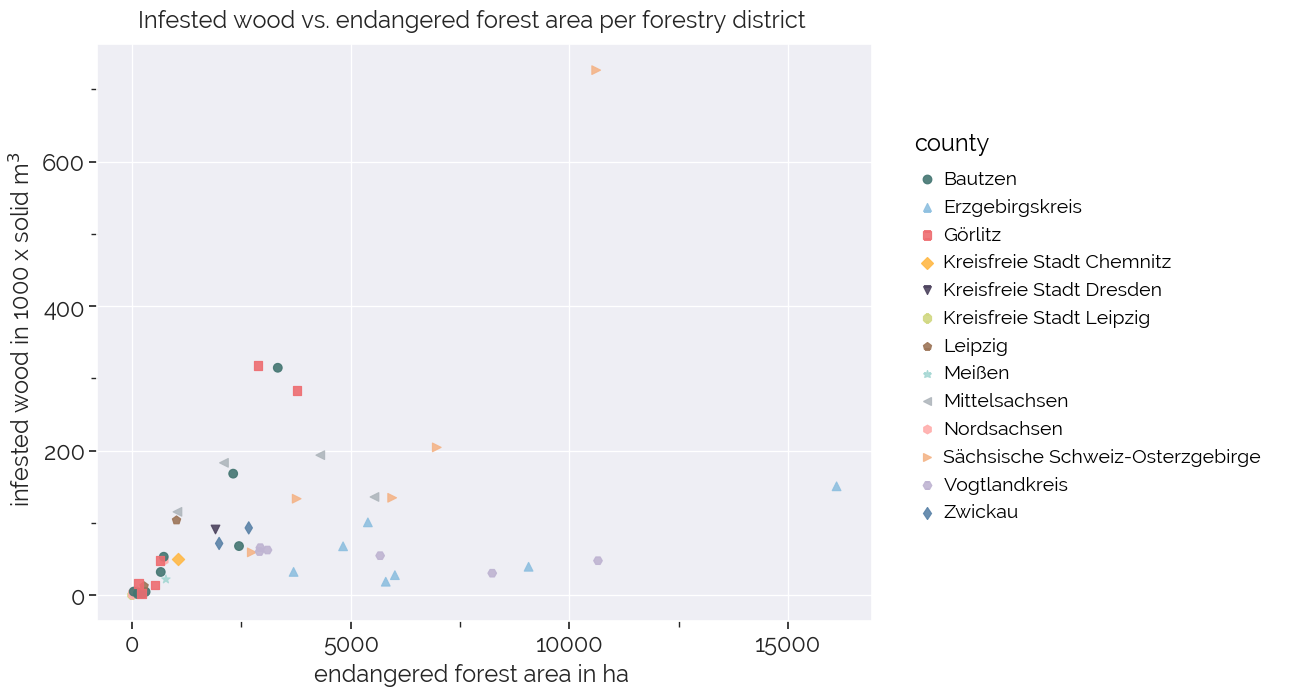

In [68]:
# make a scatterplot: infested wood vs endangered
# (one point per forestry district)

(p9.ggplot(districts_gdf, p9.aes(
    'area_endangered' , 'total_infested_wood/1000', color='county_name')) 
 + p9.geom_point(p9.aes(shape='county_name'), size=3, alpha=.9)
 + p9.scale_color_manual(mycolors[:13], name='county')
 + p9.scale_shape_manual([
     'o', '^', 's', 'D', 'v', '8', 'p', '*', '<', 'h', '>', 'H', 'd'
 ], name='county')
 + p9.ggtitle('Infested wood vs. endangered forest area per forestry district')
 + p9.xlab('endangered forest area in ha') 
 + p9.ylab('infested wood in 1000 x solid m$^3$')
 + mytheme
).draw();

Considering both plots it seems plausible that some correlation exists between the area of endangered forest and the target variable. From the second plot one can additionally conclude that every county seems to have its own distinct coefficient that roughly describes the strength of this relationship. 

## 2.4 Historic development of the bark beetle population

Now that the local context was examined, let's get an overview of the chronological infestation development. For this, we can use the timestamp feature of our dataset.

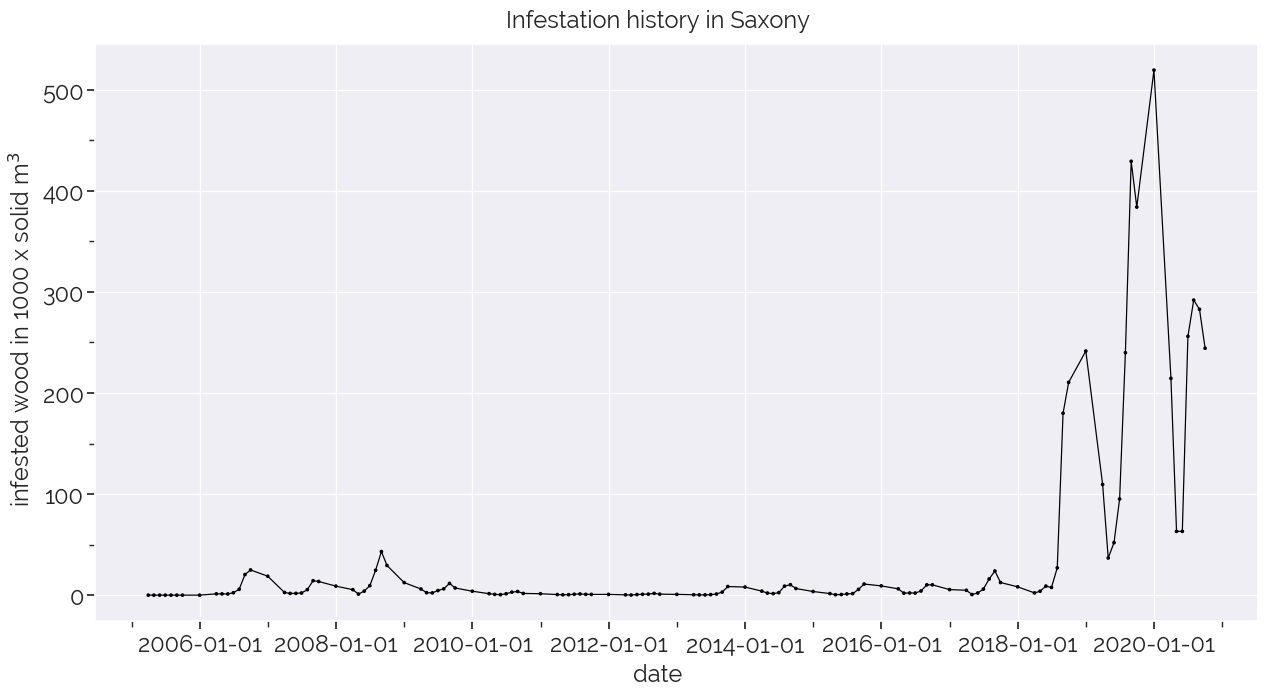

In [69]:
(p9.ggplot(
    # add together all observations of every timestamp
    p9.aes(data.groupby('timestamp')['infested_wood'].sum().index, 
           data.groupby('timestamp')['infested_wood'].sum().values / 1000)
) 
 + p9.geom_line()
 + p9.geom_point(size=.5)
 + p9.ggtitle('Infestation history in Saxony')
 + p9.xlab('date') + p9.ylab('infested wood in 1000 x solid m$^3$')
 + mythemewide
).draw();

From this plot the seriousness of the current situation is evident. The infestation (and thus resulting forest dieback) that took place during the last three years is on a completely different level than whatever came before. Even the at the time worrying infestation from 2008 is dwarfed by the amount of infested wood post 2017. 

Since the seasonal nature of the infestation is difficult to gleam from this graphic, we make recreate the plot with a logarithmically scaled y-axis.

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


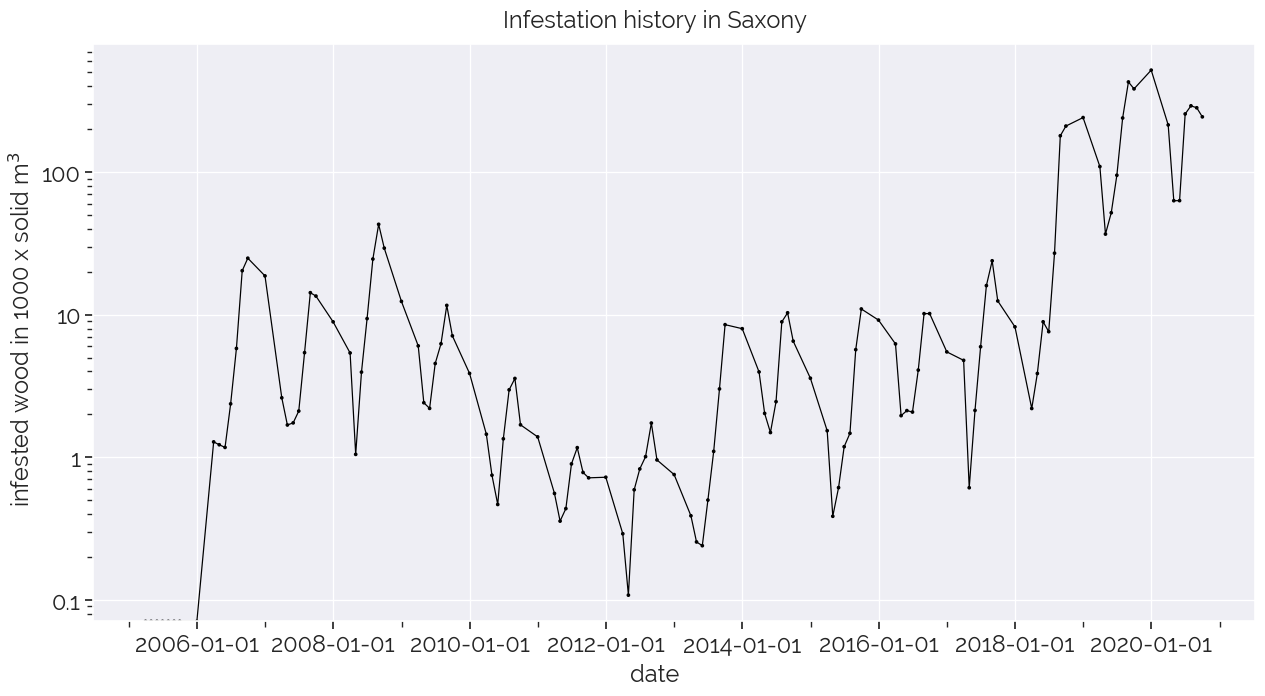

In [72]:
(p9.ggplot(
    p9.aes(data.groupby('timestamp')['infested_wood'].sum().index, 
           data.groupby('timestamp')['infested_wood'].sum().values / 1000)) 
 + p9.geom_line()
 + p9.geom_point(size=.5)
 + p9.scale_y_log10()
 + p9.ggtitle('Infestation history in Saxony')
 + p9.xlab('date') + p9.ylab('infested wood in 1000 x solid m$^3$')
 + mythemewide
).draw();

In that plot the yearly highs are more distinguishable. In the early years they seem to occur in August and September. In the later years, the infested wood peaks during the summarized months of October-December (most likely because they **are** summarized, otherwise one could assume the peak would also be September). The lowest values exist in April, but again the summarization of three months into one just before April makes it difficult to draw definite conclusions. It is however evident that there is a seasonal component/cycle to the infestation. All in all the years with the highest amount of infested wood are (in that order) 2019, 2020, 2018 (followed by 2008) and the years with the lowest total amount of infested wood are 2011, 2012 and 2010. We will keep this in mind for the investigation of meteorological parameters.

In [ ]:
###############################################################################

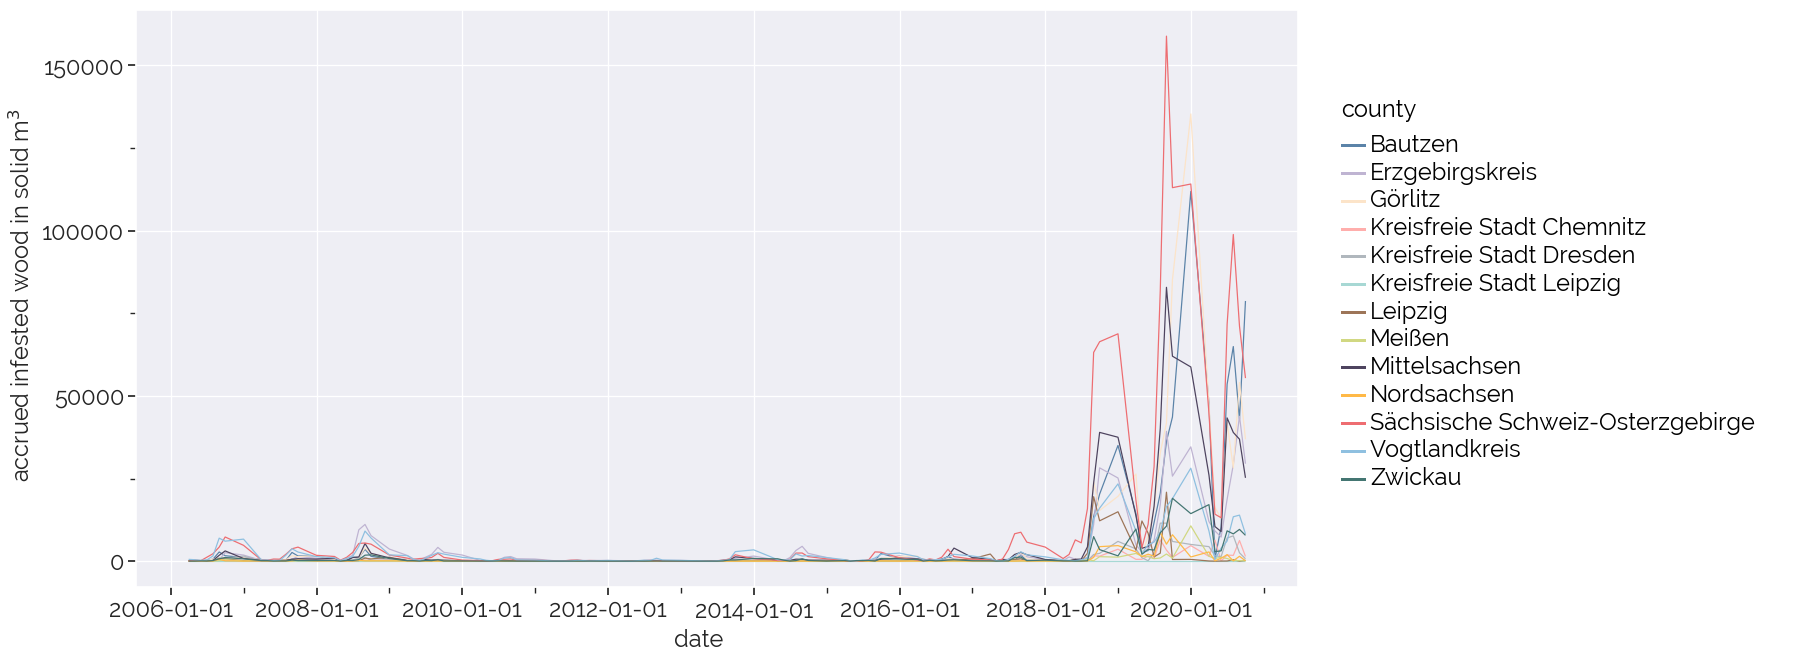

In [12]:
grouped_by_county = data[data['year'] > 2005].groupby(['timestamp','county_name'])['infested_wood'].sum().reset_index()

(
    p9.ggplot(grouped_by_county, p9.aes('timestamp', 'infested_wood', color='county_name'))
    + p9.geom_line()
    + p9.scale_color_manual(mycolors[:13][::-1], name='county')
    + p9.xlab('date') + p9.ylab('accumulated infested wood in solid m$^3$')
    + mythemewide
).draw();

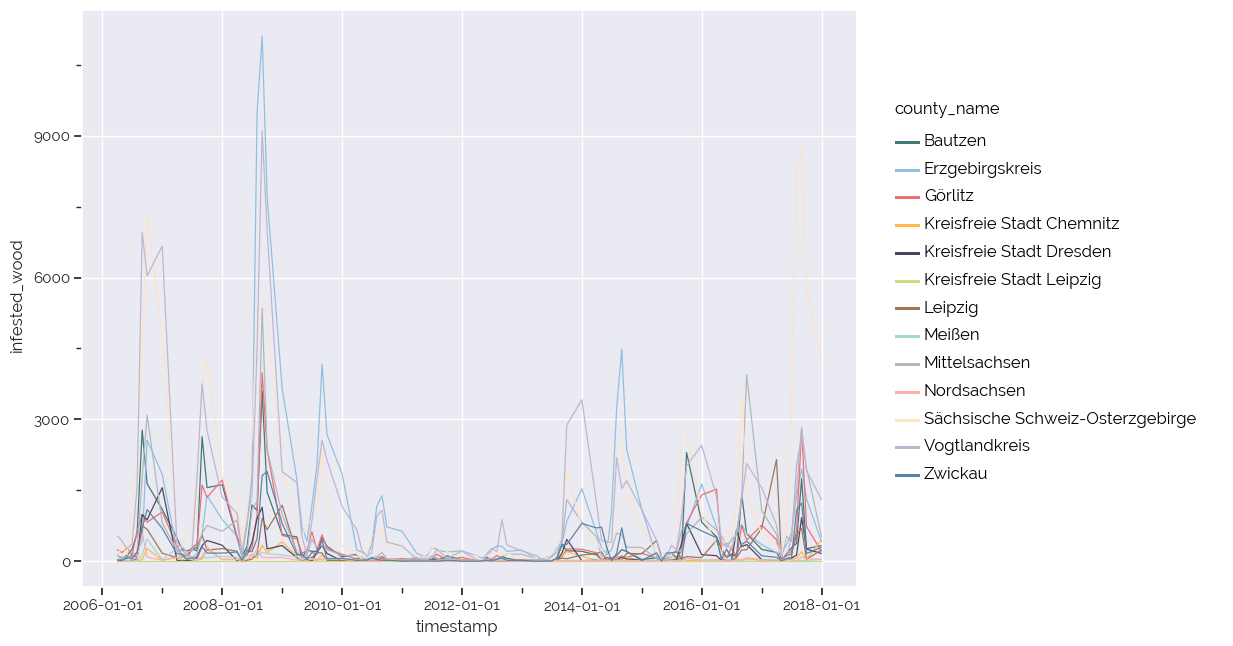

In [13]:
(
    p9.ggplot(grouped_by_county[grouped_by_county['timestamp'] < pd.Timestamp('2018-01-01')], p9.aes('timestamp', 'infested_wood', color='county_name')) 
    + p9.geom_line()
    + p9.scale_color_manual(mycolors[:13])
    + p9.theme_seaborn()
).draw();

In [14]:
data[(data['infested_wood']>0) & (data['infested_wood']<=100)].shape

(4552, 74)

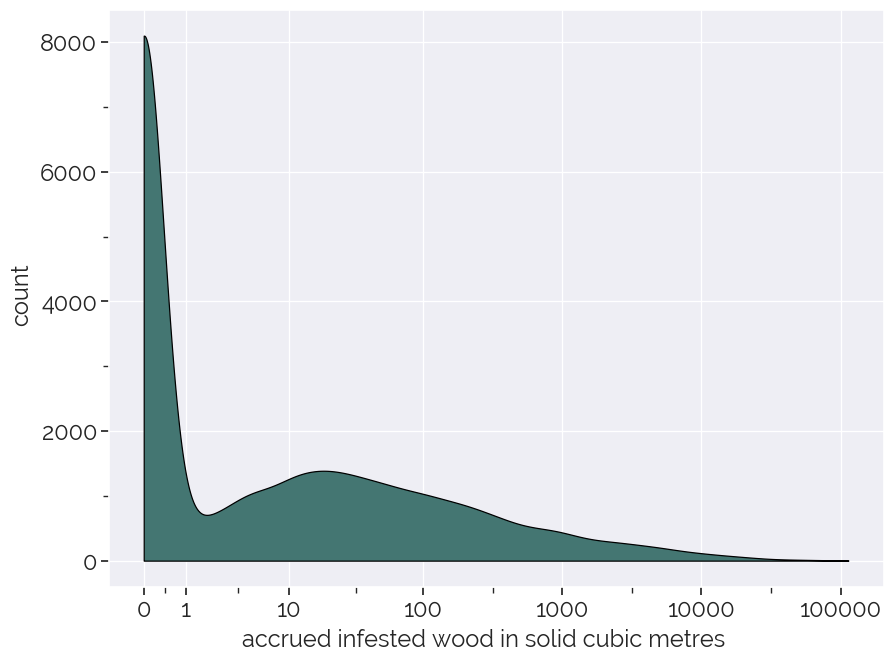

In [15]:
#TODO: Histogram of observations
(
    p9.ggplot(data, p9.aes(x='infested_wood')) 
    + p9.geom_density(p9.aes(y='..count..'), fill=mycolors[0])
    + p9.theme_seaborn()
    + p9.scale_x_continuous(trans="log1p", breaks=[0,1,10,100,1000,10000, 100000])
    + p9.xlab('accumulated infested wood in solid cubic metres') + p9.ylab('count')
    + mytheme
).draw();


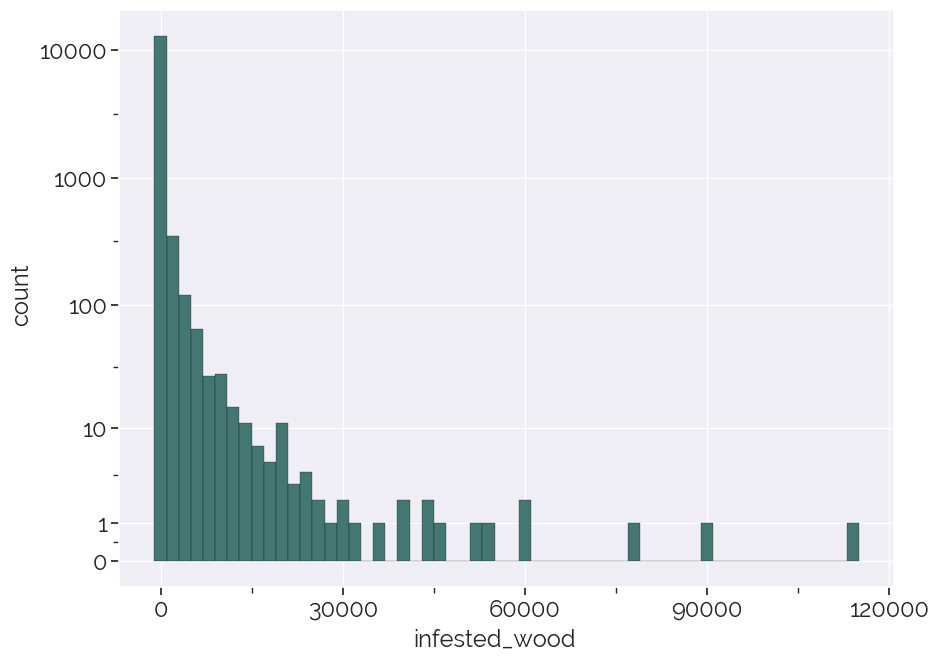

In [16]:
#TODO: Histogram of observations

p9.options.figure_size = (10, 7.5)

(
    p9.ggplot(data, p9.aes(x='infested_wood')) 
    + p9.geom_histogram(binwidth=2000, fill=mycolors[0], color='black', size=.1)
    + p9.scale_y_continuous(trans="log1p", breaks=[0,1,10,100,1000,10000])
    + mytheme
).draw();


# Meteorological

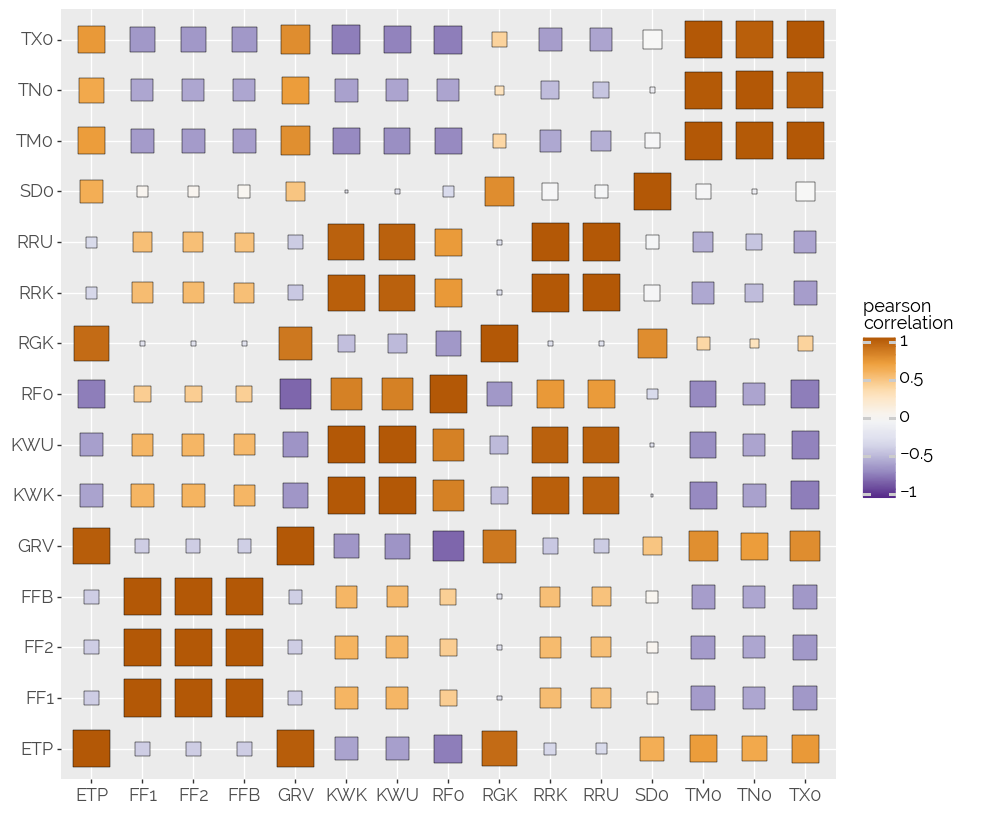

In [17]:
def heatmap(x, y, size, color):
    p9.options.figure_size = (10,10)
    (p9.ggplot(p9.aes(x,y, size=size, fill=color, group=1))
    + p9.geom_point(shape='s', stroke=.2#, position=p9.position_nudge(x=-0.5, y=-0.5)
                   )
    + p9.scale_fill_distiller(
        type='div',
        name='pearson \ncorrelation\n', 
        limits=[-1,1],
        palette=4)
     + p9.scale_size_continuous(range=[-10,15], limits=[0,1], guide=False)
     + p9.xlab('') + p9.ylab('')
     + p9.theme(text= p9.element_text(size=13, family='sans-serif'))
    ).draw();

    

columns = [
    'TX0', # maximum temperature of the day in degrees Celsius
    'TM0', # mean temperature of the day in degrees Celsius
    'TN0', # minimum temperature of the day in degrees Celsius
    'RF0', # mean relative humidity of the day in %
    'SD0', # total sunshine duration of the day in h
    'RRU', # total precipitation of the day in mm
    'RRK', # corrected total precipitation of the day in mm (corrects systematic errors of the measuring device and installation location such as wetting/evaporation losses)
    'FF1', # mean wind velocity of the day 10 metres above ground in m*s-1
    'FF2', # mean wind velocity of the day 2 metres above ground in m*s-1
    'FFB', # wind speed of the day on the beaufort scale in bft
    'RGK', # total global solar irradiation of the day in kWh*m-2
    'ETP', # potential evaporation for the day in mm
    'GRV', # potential evapotranspiration for the day in mm
    'KWU', # 
    'KWK'
]


corr = data[columns].corr()
# Unpivot the dataframe, so we can get pair of arrays for x and y
corr = pd.melt(corr.reset_index(), id_vars='index') 
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color = corr['value']
)

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


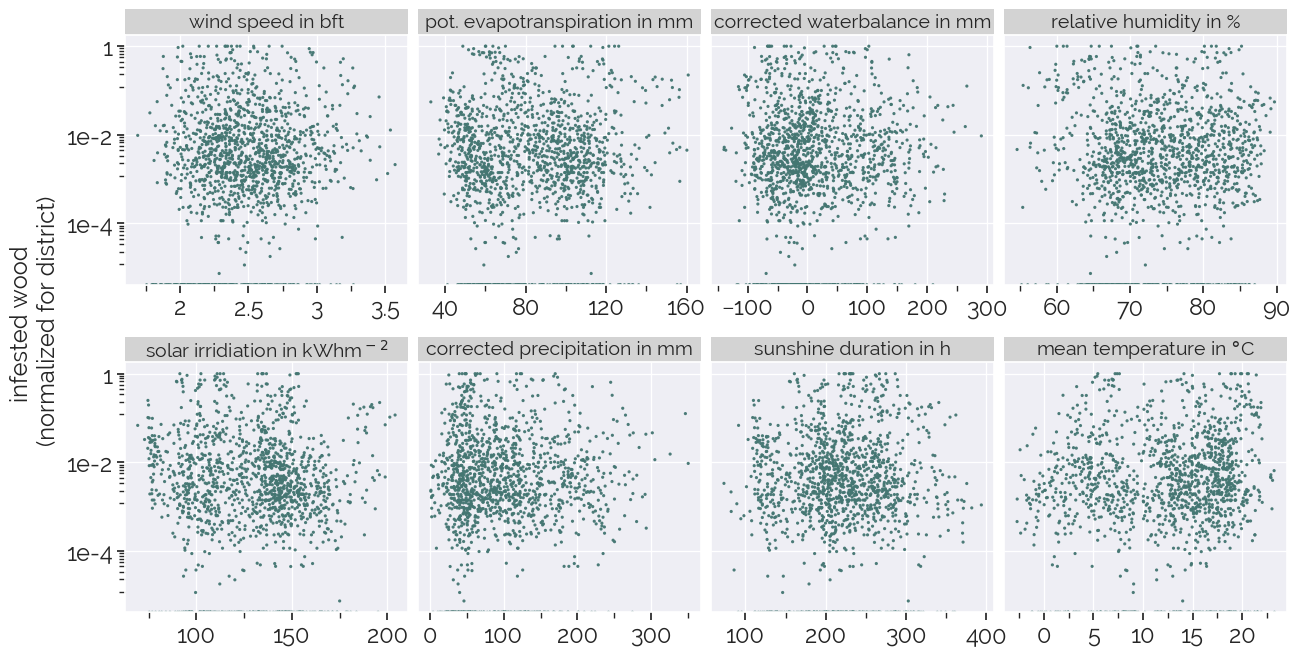

In [18]:
# Initial graphic

def mylabeller(var):
    label_dict = {
        'FFB': 'wind speed in bft',
        'GRV': 'pot. evapotranspiration in mm',
        'KWK': 'corrected waterbalance in mm',
        'RF0': 'relative humidity in %',
        'RGK': r'solar irridiation in kWhm$^-$$^2$',
        'RRK': 'corrected precipitation in mm',
        'SD0': 'sunshine duration in h',
        'TM0': 'mean temperature in $°$C',
    }
    return label_dict.get(var)


draw = data[(data['year'].isin(range(2006,2020)))].copy()
draw['infested_wood'] = draw.groupby(['county_name', 'timestamp'])['infested_wood'].transform('sum')
for v in ['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK']:
    draw[v] = draw.groupby(['county_name', 'timestamp'])[v].transform('mean')
draw.drop_duplicates(['county_name', 'timestamp'], inplace=True)
draw['infested_wood'] = draw.groupby('county_name')['infested_wood'].transform(lambda x: minmax_scale(x))
draw = pd.melt(draw, id_vars=['infested_wood'], value_vars=['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK'])

p9.options.figure_size = (15,7.5)

(p9.ggplot(p9.aes('value', 'infested_wood'), data=draw)
 + p9.geom_point(size=.3, alpha=.9, color=mycolors[0])
 + p9.facet_wrap('variable', scales='free_x', ncol=4, labeller=mylabeller)
 + p9.scale_y_log10()
 + p9.xlab('') + p9.ylab('infested wood \n(normalized for district)')
 + mythemewide
).draw();

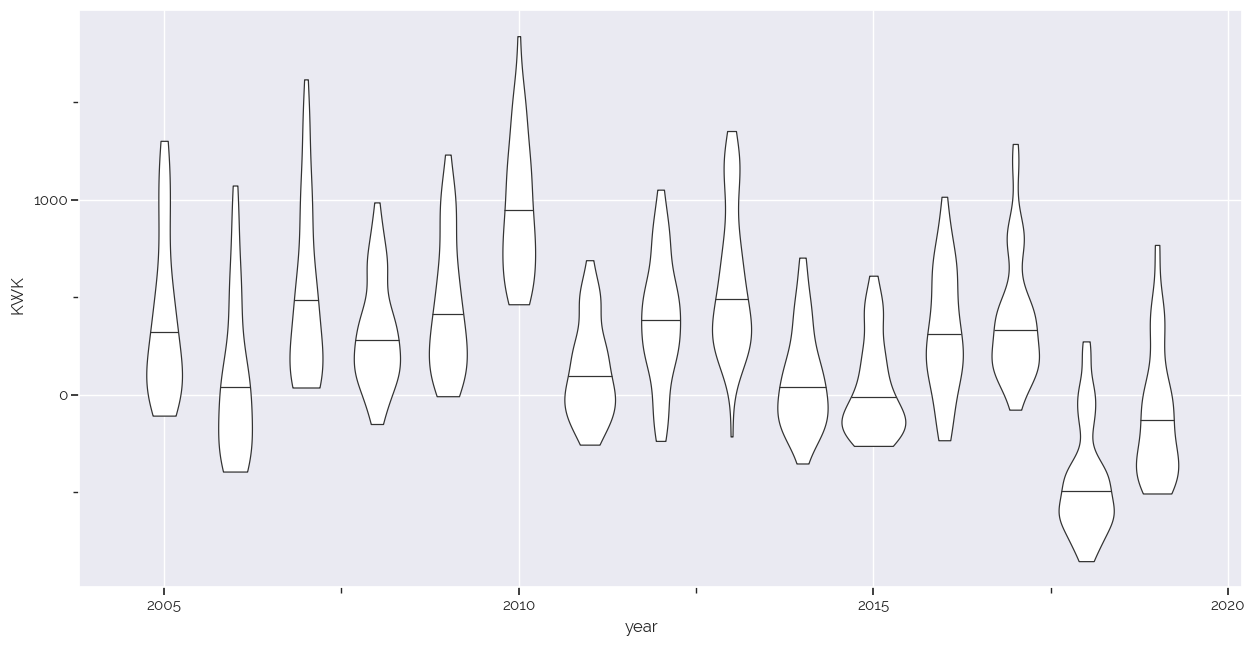

In [19]:
draw = data[(data['year'].isin(range(2005,2020))) & data['timestamp'].map(lambda x: x.month).isin(range(13))].copy()

draw['KWK'] = draw.groupby(['fdist_newname', 'year'])['KWK'].transform('sum').copy()

draw.drop_duplicates(['year', 'fdist_newname'], inplace=True)

(p9.ggplot(p9.aes('year', 'KWK', group='year'), data=draw)
    + p9.geom_violin(draw_quantiles=(0.5))
    + p9.theme_seaborn()).draw();

In [20]:
def climate_boxplot(param, aggfunc, data=data):
    '''
    TODO: documentation
    '''
    # figure size
    p9.options.figure_size = (15, 5)
    
    # select data from winter 2005/2006 untill winter 2019/2020
    draw = data[data['timestamp'].isin(pd.date_range(start='2005-10-01', end='2020-04-01', freq='M'))].copy()
    
    # make a dummy feature that distinguishes winter and summer
    # winter = months 10,11,12,01,02,03; summer = months 4,5,6,7,8,9
    draw['season'] = draw['timestamp'].map(lambda x: 'winter' if x.month not in range(4,10) else 'summer')
    
    # logically group winters together in 'winteryear' column 
    # winter at end of preceeding year should be grouped with winter at beginning of subsequent year
    # for example winter 2007/2008 should go 'in between' summer 2007 and summer 2008
    # in this case the new column takes both observations and maps them to the preceeding year
    draw['winteryear'] = draw[['year', 'timestamp']].apply(lambda x: x[0] if x[1].month != 3 else x[0]-1, axis=1)
    
    # every data point is aggregated for the year for every forestry district in groupby
    draw[param] = draw.groupby(['fdist_newname', 'season', 'winteryear'])[param].transform(aggfunc).copy()
    draw.drop_duplicates(['winteryear', 'season', 'fdist_newname'], inplace=True)
    
    #plot
    (p9.ggplot(p9.aes('factor(winteryear)', param, fill='factor(season)'), data=draw)
     + p9.geom_boxplot(data=draw[draw['season']=='summer'], 
                       width=.35)
    + p9.geom_boxplot(data=draw[draw['season']=='winter'], 
                      width=.35,
                      position=p9.position_nudge(x=0.5))
     + p9.scale_x_discrete(expand=(0, 0, 0, 1))
     + p9.scale_fill_manual(mycolors[1:3], name='season')
     + p9.xlab('year') + p9.ylab(mylabeller(param))
     + mythemewide
    ).draw();

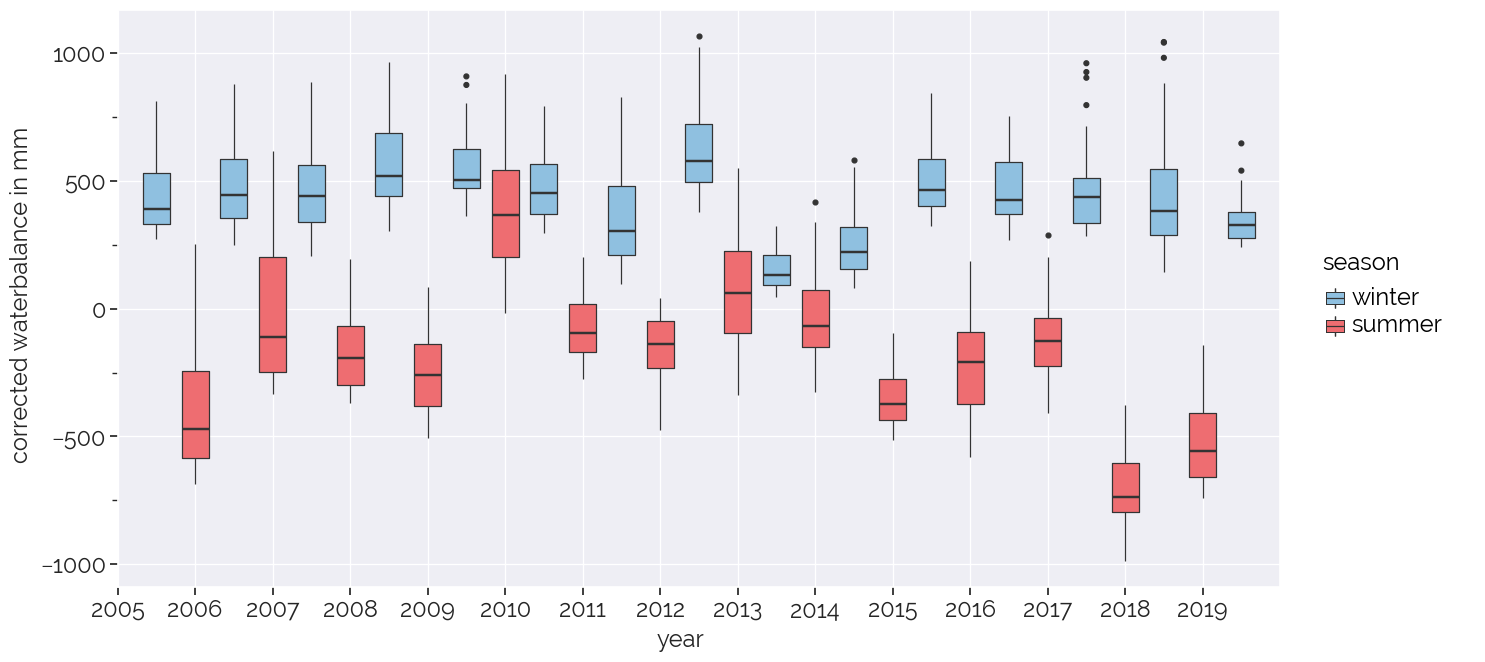

In [21]:
climate_boxplot('KWK', 'sum') # corrected waterbalance (precipitation - evapotranspiration)

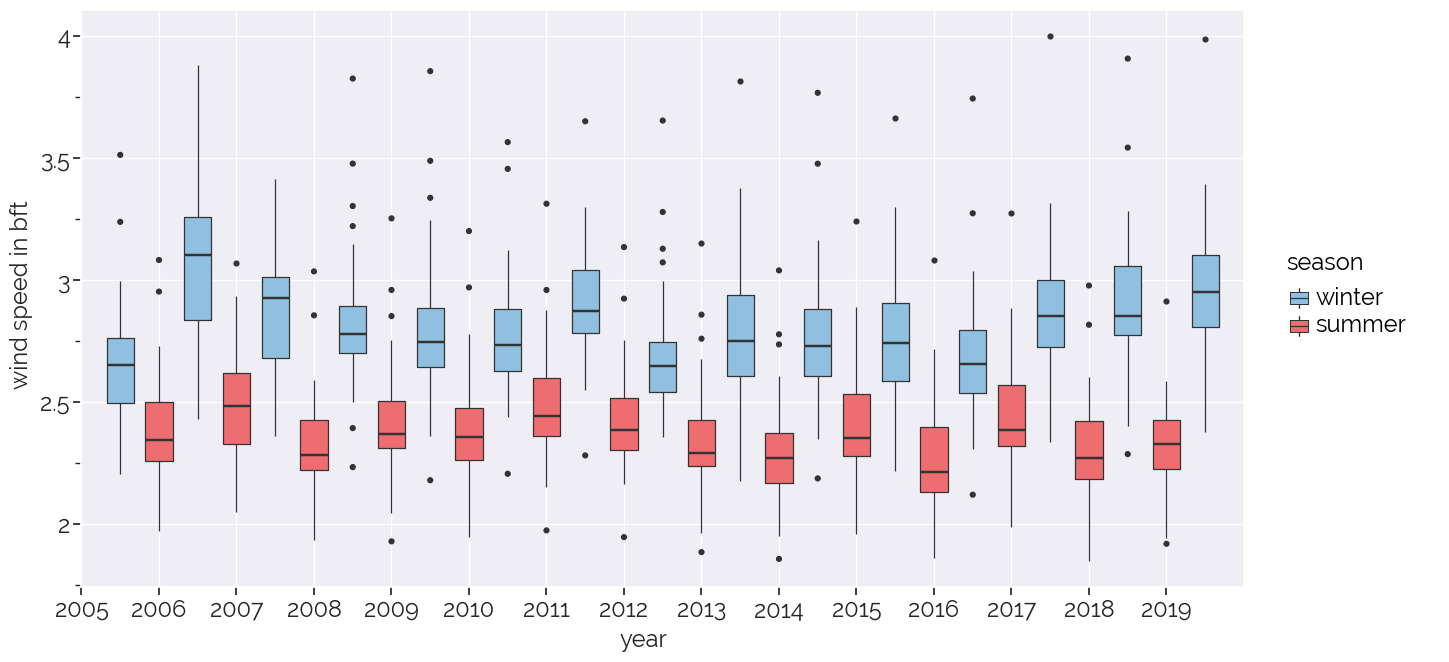

In [22]:
climate_boxplot('FFB', 'mean') # wind speed in bft

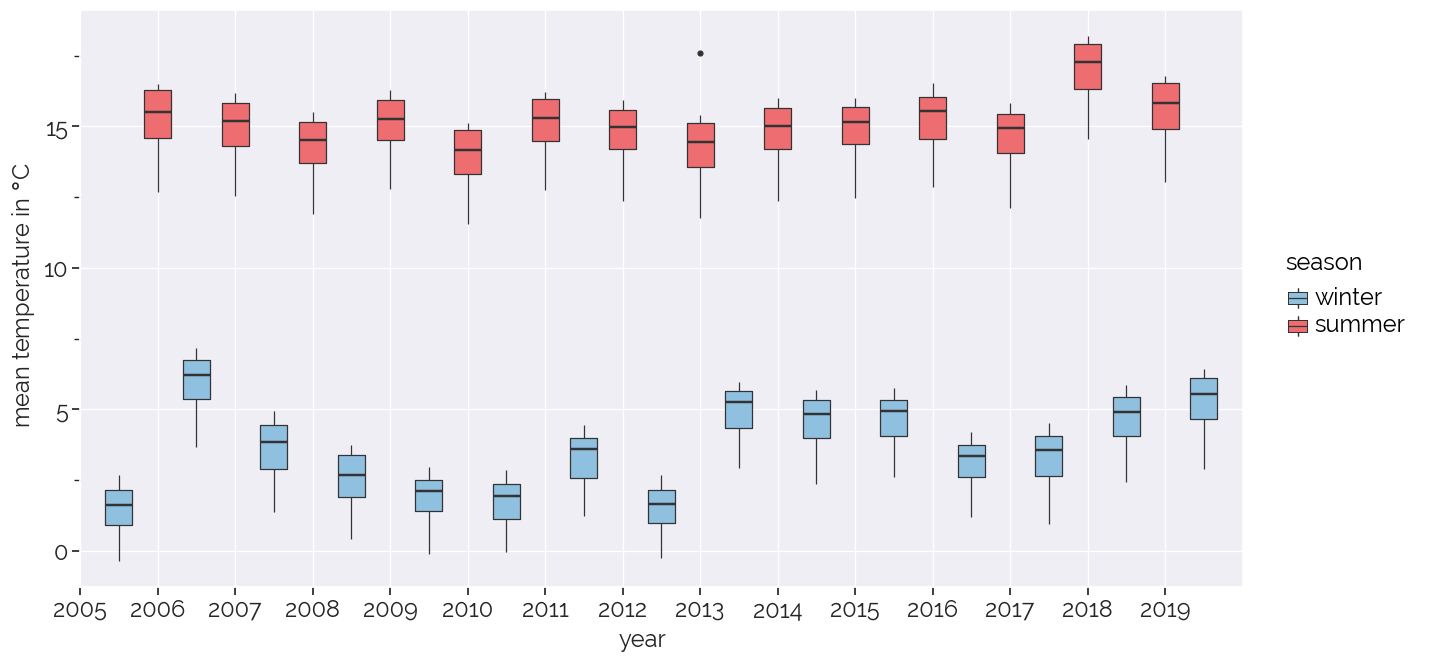

In [23]:
climate_boxplot('TM0', 'mean') # mean temperature

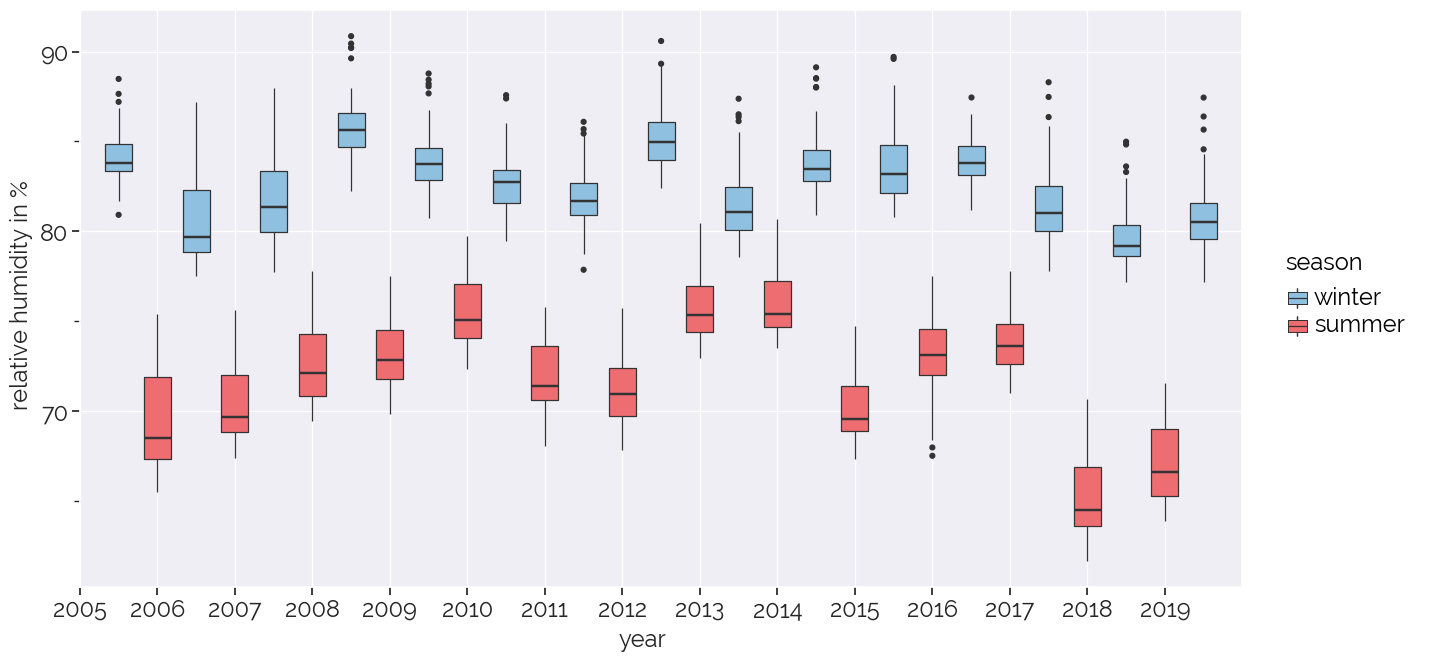

In [24]:
climate_boxplot('RF0', 'mean') # relative humidity

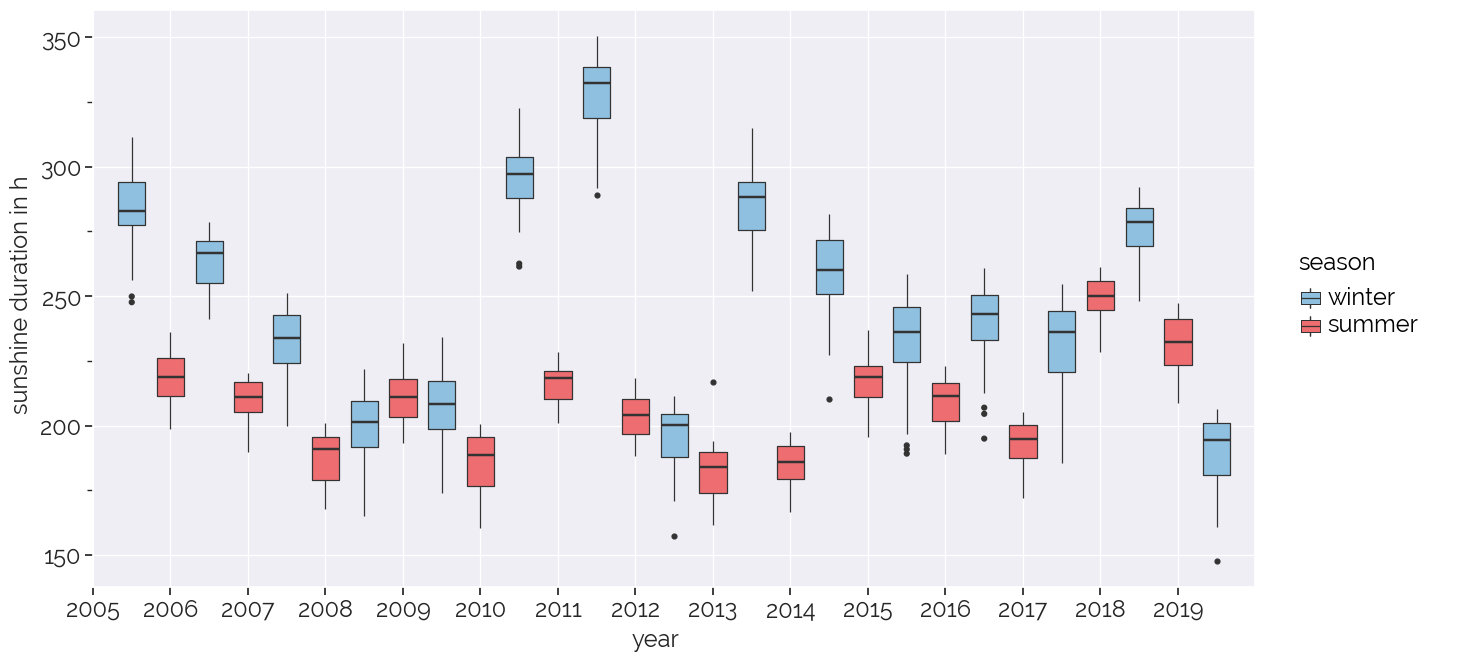

In [25]:
climate_boxplot('SD0', 'mean') # total sunshine duration

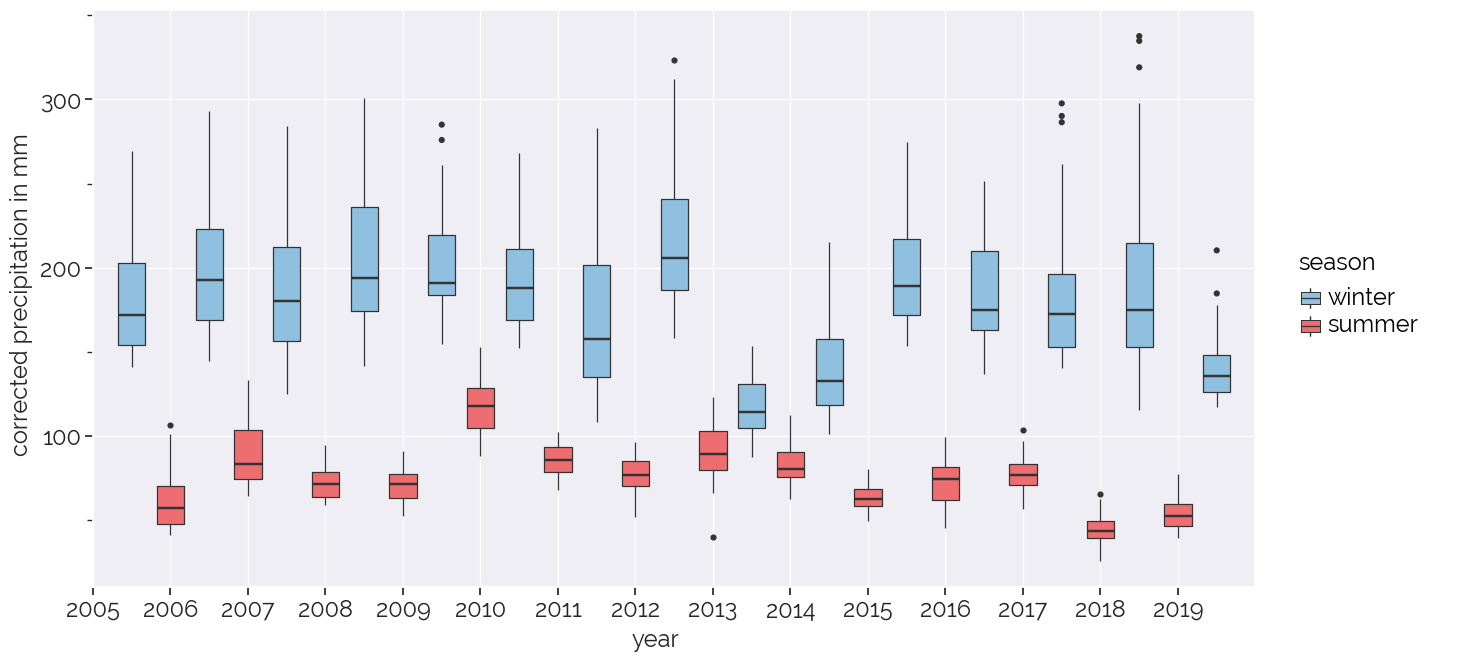

In [26]:
climate_boxplot('RRK', 'mean') # precipitation

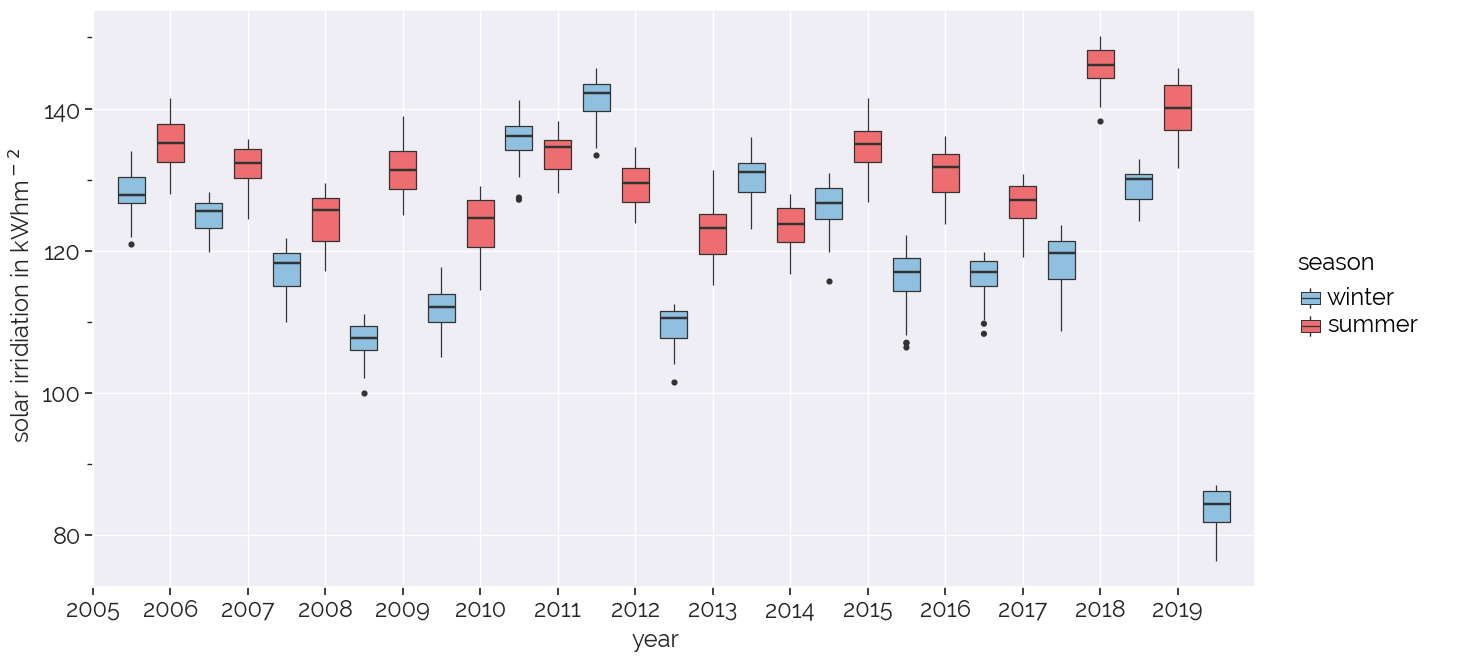

In [27]:
climate_boxplot('RGK', 'mean') # global solar irridiation

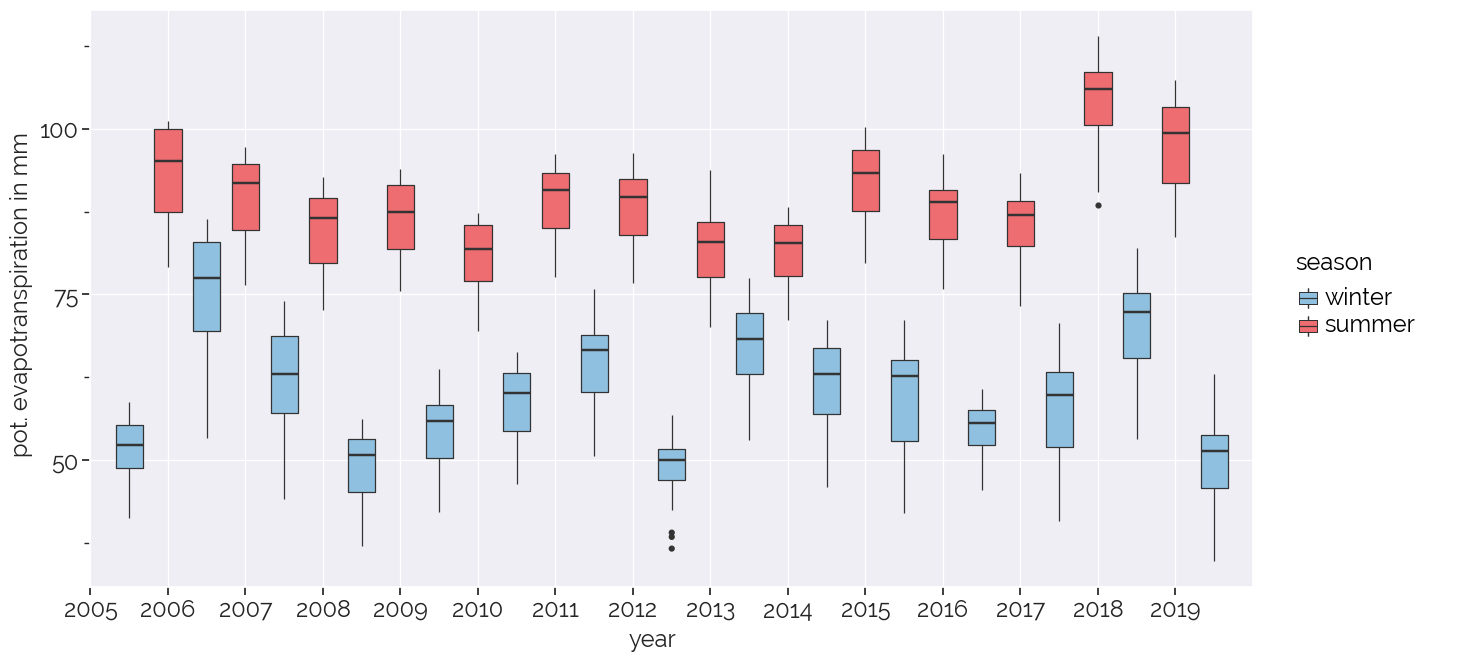

In [28]:
climate_boxplot('GRV', 'mean') # potential evapotranspiration

In [31]:
draw.head()

,fdist_id,year,timeframe,forest_ownership,infested_wood,disposed_wood,county_name,fdist_name,area_nse,area_nsne,area_se,area_sne,centroid_xcoord,centroid_ycoord,area_fdist,endangered_forest_density,TX0,TM0,TN0,RF0,SD0,RRU,RRK,FF1,FF2,FFB,RGK,ETP,GRV,KWU,KWK,HS8,HS16,fdist_newname,id,timestamp,prev_disposed_wood,prev_infested_wood,prev_infested_wood_ofo,TX0_rollyr,TM0_rollyr,TN0_rollyr,RF0_rollyr,SD0_rollyr,RRU_rollyr,RRK_rollyr,FF1_rollyr,FF2_rollyr,FFB_rollyr,RGK_rollyr,ETP_rollyr,GRV_rollyr,KWU_rollyr,KWK_rollyr,prev_infested_wood_rollyr,prev_disposed_wood_rollyr,HS8_rollyr,HS16_rollyr,TX0_rollsr,TM0_rollsr,TN0_rollsr,RF0_rollsr,SD0_rollsr,RRU_rollsr,RRK_rollsr,FF1_rollsr,FF2_rollsr,FFB_rollsr,RGK_rollsr,ETP_rollsr,GRV_rollsr,KWU_rollsr,KWK_rollsr,TX0_rollwr,TM0_rollwr,TN0_rollwr,RF0_rollwr,SD0_rollwr,RRU_rollwr,RRK_rollwr,FF1_rollwr,FF2_rollwr,FFB_rollwr,RGK_rollwr,ETP_rollwr,GRV_rollwr,KWU_rollwr,KWK_rollwr,area_endangered,demolition_wood,disposed_demolition_wood,disposing_rate_demolition,disposing_rate_infested_yr
0,2501,2007,06 Juni,SW,5.0,0.0,Bautzen,Elsterheide,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,24.916160,18.961279,12.705051,69.536366,222.087200,66.932660,72.526601,2.973737,2.187542,2.314478,150.442419,110.063631,116.130629,-43.130978,38.034343,374.090903,374.090903,Elsterheide,Bautzen-Elsterheide-SW,2007-06-30,0.0,0.0,0.0,16.969445,12.008333,6.658670,72.416498,258.143315,96.325082,107.424327,3.881285,2.851936,2.747671,135.472419,91.670115,95.844697,4.653114,15.754209,0.0,NaN,1878.104523,1878.104523,23.674299,17.260886,10.374411,65.548933,246.475863,46.613805,50.651179,3.159596,2.322222,2.404658,144.731032,102.825754,106.099662,-56.215656,-52.174580,3.421530,2.251927,0.980976,26.428021,89.936922,48.678787,54.732491,1.534325,1.127217,1.030228,42.071269,26.838158,28.529911,21.840628,27.894333,26.85,0.0,0.0,1.000000,1.0
6,2501,2008,04 April,SW,1.0,0.0,Bautzen,Elsterheide,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,13.134343,8.478114,3.410774,76.055556,121.405395,67.974406,75.021544,2.989899,2.194276,2.314478,92.019860,56.094611,56.256563,11.879798,82.435019,8.413636,8.413636,Elsterheide,Bautzen-Elsterheide-SW,2008-04-30,0.0,0.0,0.0,14.354910,10.036279,5.425028,76.156510,212.176339,107.609259,119.113271,3.723429,2.739675,2.675140,121.873767,79.747757,81.276039,27.861504,39.365516,19.0,NaN,1531.931805,1531.931805,21.161054,15.610550,9.648597,71.580584,190.639893,73.080807,79.496071,3.203087,2.354770,2.433670,125.470429,87.895175,90.977665,-14.814366,-8.399103,2.516255,1.487336,0.400486,26.910812,77.904262,47.379237,52.910157,1.414590,1.041526,0.972204,39.425702,23.866780,23.858137,23.512458,29.043379,26.85,50.0,25.0,0.500000,NaN
16,2501,2009,01 Januar-März,SW,3.0,3.0,Bautzen,Elsterheide,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,3.875757,1.084624,-2.128171,85.136478,167.395623,145.754215,167.470713,3.820763,2.804377,2.745679,111.766671,61.713807,54.355219,84.040402,121.000686,0.000000,0.000000,Elsterheide,Bautzen-Elsterheide-SW,2009-03-31,0.0,2.0,0.0,13.635157,9.321970,4.679153,78.137262,192.499046,104.937375,117.423065,3.284961,2.410101,2.462542,116.831931,76.455276,73.463440,28.482098,40.967873,10.0,NaN,1432.359093,1432.359093,20.996127,15.256622,9.153423,70.908979,195.974355,55.088720,60.390908,2.824860,2.073737,2.225758,127.692985,89.074859,91.365937,-33.986139,-28.683951,2.091395,1.129106,0.068294,28.455182,63.007912,51.595344,58.151740,1.248354,0.915488,0.899776,35.323626,21.278564,18.520314,30.316778,36.873233,26.85,0.0,0.0,1.000000,NaN
20,2501,2010,07 Juli,SW,0.0,0.0,Bautzen,Elsterheide,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,27.900670,21.678116,14.262289,63.650502,289.538721,100.070365,104.990905,2.557576,1.900000,2.100000,174.654211,132.592251,134.930976,-32.521886,504.478813,442.372731,442.372731,Elsterheide,Bautzen-Elsterheide-SW,2010-07-31,0.0,

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


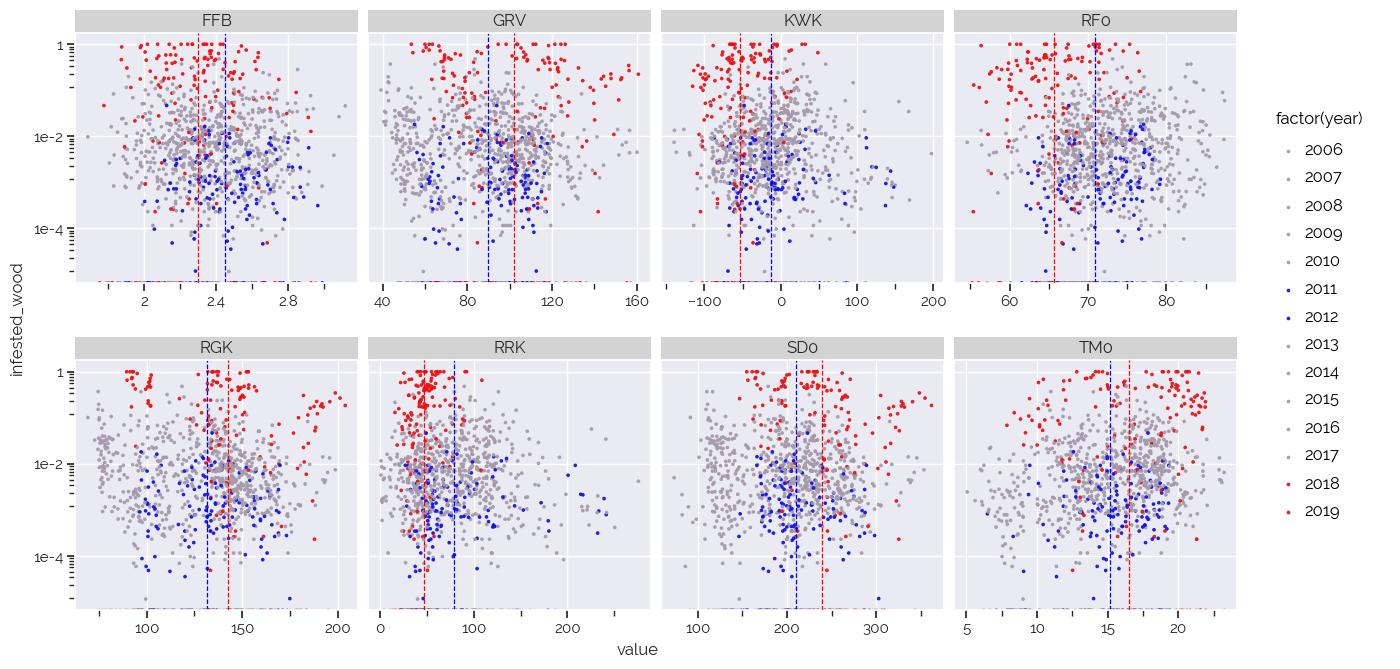

In [32]:
# second graphic -only summer
draw = data.copy()
draw = data[(data['year'].isin(range(2006,2020))) & data['timestamp'].map(lambda x: x.month).isin(range(4,10))].copy()
draw['infested_wood'] = draw.groupby(['county_name', 'timestamp'])['infested_wood'].transform('sum')

for v in ['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK']:
    draw[v] = draw.groupby(['county_name', 'timestamp'])[v].transform('mean')

draw.drop_duplicates(['county_name', 'timestamp'], inplace=True)
draw['infested_wood'] = draw.groupby('county_name')['infested_wood'].transform(lambda x: minmax_scale(x))


draw = pd.melt(draw, id_vars=['infested_wood', 'year'], value_vars=['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK'])

# vline values
mlow = {}
mhigh = {}


for v in draw.variable.unique():
    ml = np.nanmean(draw.loc[(draw['variable']==v) & (draw['year'].isin([2011, 2012]))]['value'])
    mh = np.nanmean(draw.loc[(draw['variable']==v) & (draw['year'].isin([2018, 2019]))]['value'])
    mlow[f'{v}'] = ml
    mhigh[f'{v}'] = mh


draw['mean_low'] = draw['variable'].map(lambda x: mlow.get(x))
draw['mean_high'] = draw['variable'].map(lambda x: mhigh.get(x))

    # TODO: Legende: 2011, 2012 - 2018, 2019 - other  
p9.options.figure_size = (15,7.5)

(p9.ggplot(p9.aes('value', 'infested_wood'), data=draw)
 + p9.geom_point(p9.aes(color='factor(year)'), size=.5, alpha=.9)
 + p9.facet_wrap('variable', scales='free_x', ncol=4)
 + p9.geom_vline(p9.aes(xintercept='mean_low'), color='blue', linetype='--')
 + p9.geom_vline(p9.aes(xintercept='mean_high'), color='red', linetype='--')
 + p9.theme_seaborn()
 + p9.scale_y_log10()
 + p9.theme(subplots_adjust={'hspace': 0.31})
 + p9.scale_color_manual(['#a49aab', '#a49aab', '#a49aab', '#a49aab', '#a49aab', '#1313ec', '#1313ec', '#a49aab', '#a49aab', '#a49aab', '#a49aab', '#a49aab', '#ec1313', '#ec1313'])
).draw();

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


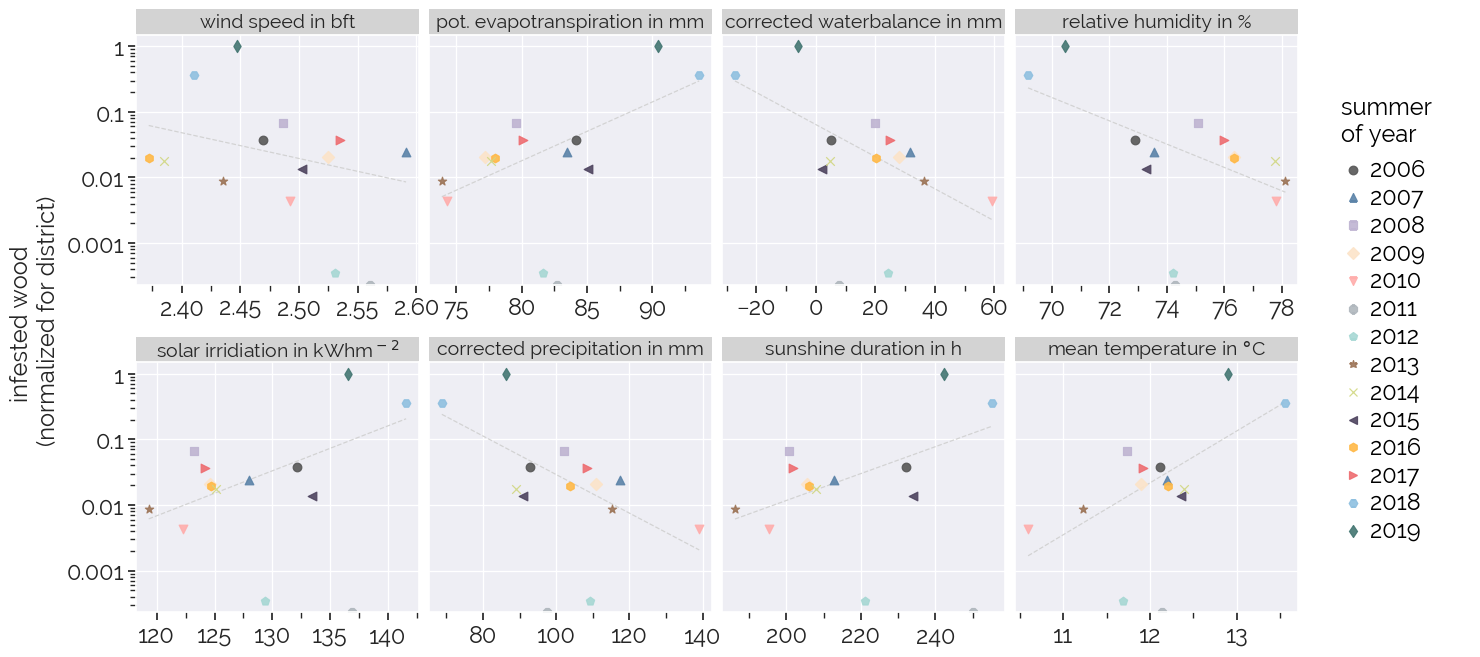

In [33]:
# only one dot per year (whole year, not just summer)
# maybe this is better because it takes the mean of a whole year and does not have individual dots that represent timeframes "ruin" the trend (in july its always warmer)
# 2008 still not special in any way

draw = data[(data['year'].isin(range(2006,2020)))].copy()
draw['infested_wood'] = draw.groupby(['year'])['infested_wood'].transform('mean')

for v in ['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK']:
    draw[v] = draw.groupby(['year'])[v].transform('mean')
    
    
draw.drop_duplicates(['year'], inplace=True)
draw['infested_wood'] = draw['infested_wood'].transform(lambda x: minmax_scale(x))
draw = pd.melt(draw, id_vars=['infested_wood', 'year'], value_vars=['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK'])


(p9.ggplot(p9.aes('value', 'infested_wood', color='factor(year)', shape='factor(year)'), data=draw)
 + p9.geom_smooth(p9.aes('value', 'infested_wood', group=1), method='lm', se=False, color='lightgrey', size=.5, linetype='--')
 + p9.geom_point(size=3, alpha=.9)
 + p9.facet_wrap('variable', scales='free_x', ncol=4, labeller=mylabeller)
 + p9.xlab('') + p9.ylab('infested wood \n(normalized for district)') 
 + p9.scale_y_log10()
 + p9.scale_color_manual(mycolors[:14][::-1], name='summer \nof year')
 + p9.scale_shape_manual([ 
    'o',  # circle
    '^',  # triangle up
    's',  # square
    'D',  # Diamond
    'v',  # triangle down
    '8',  # octagon
    'p',  # pentagon
    '*',  # star
    'x',  # x
    '<',  # triangle left
    'h',  # hexagon1
    '>',  # triangle right
    'H',  # hexagon1
    'd'   # thin diamond
 ], name='summer \nof year')
 + mythemewide
).draw();

# Other

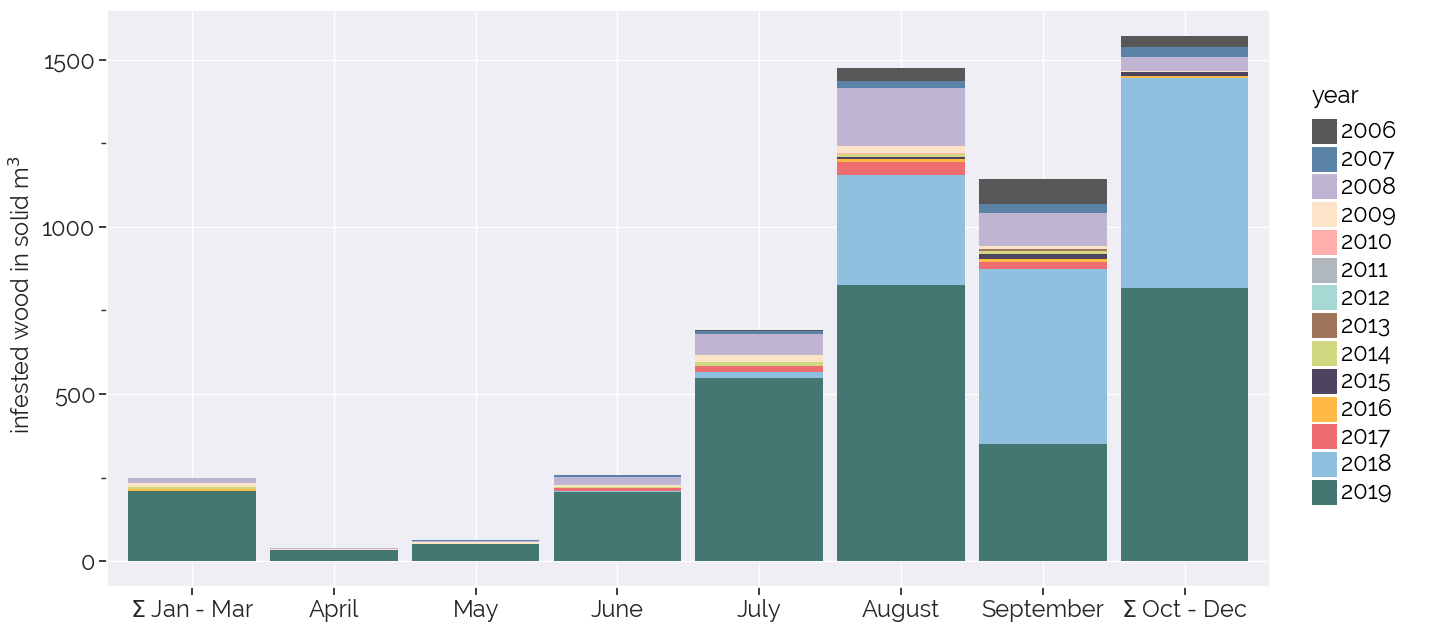

In [34]:
draw = data[(data['year'].isin(range(2006,2020)))].copy()

draw = pd.DataFrame(draw.groupby(['year', 'timeframe'])['infested_wood'].median()).reset_index()
    
(p9.ggplot(p9.aes('timeframe', 'infested_wood', fill='factor(year)'), data=draw)
 + p9.geom_col()
 + p9.scale_x_discrete(labels=[r'$\Sigma$ Jan - Mar', 'April', 'May', 'June', 'July', 'August', 'September', r'$\Sigma$ Oct - Dec'])
 + p9.scale_fill_manual(mycolors[:14][::-1], name='year')
 + p9.xlab('') + p9.ylab(r'infested wood in solid m$^3$')
 + mythemewide
).draw();

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 108 rows containing missing values.


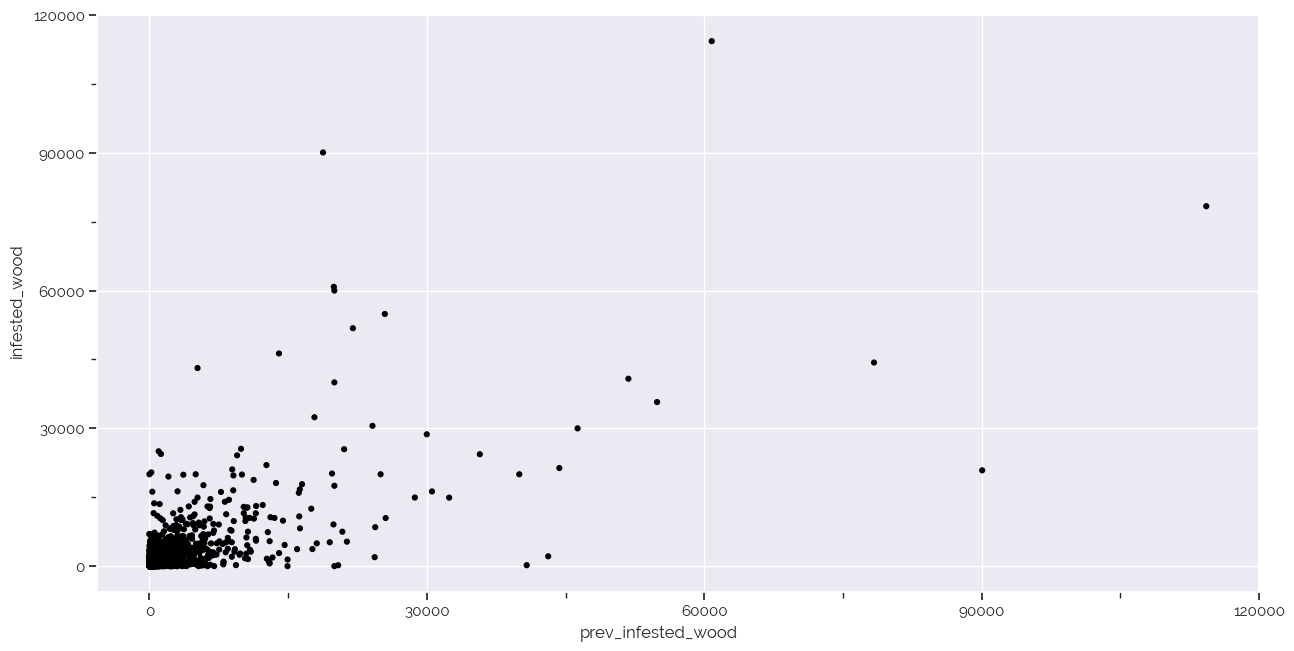

In [36]:
(p9.ggplot(p9.aes('prev_infested_wood', 'infested_wood'), data=data)
 + p9.geom_point()
 + p9.theme_seaborn()
).draw();

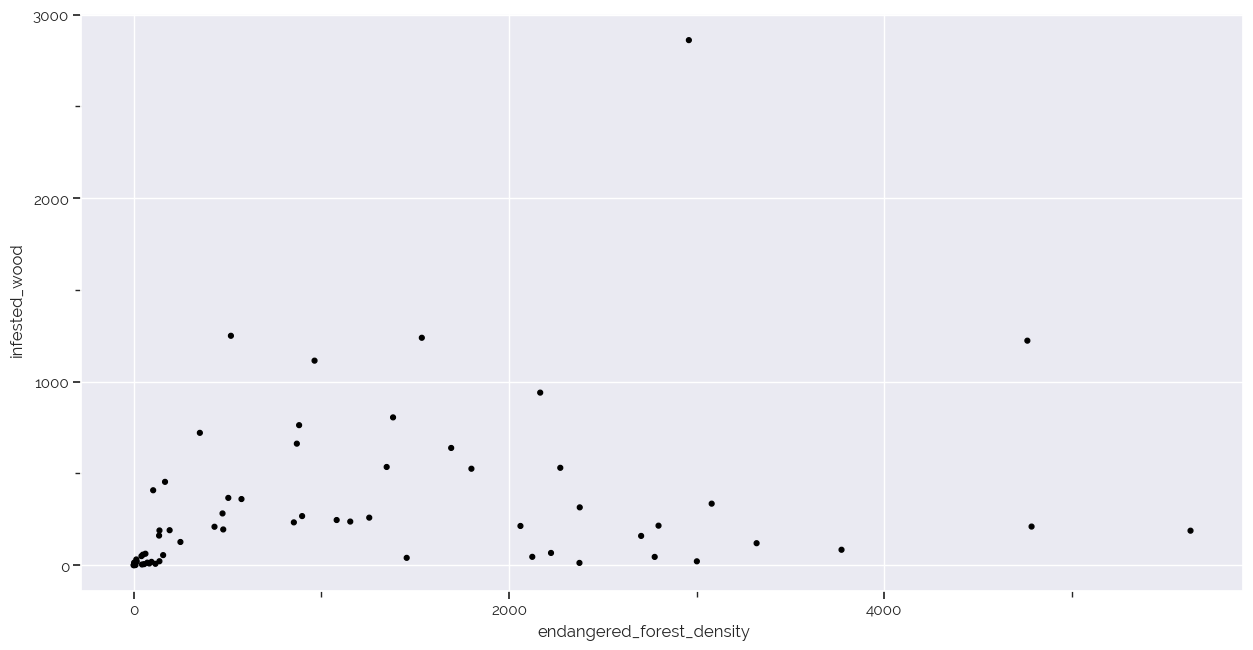

In [37]:
draw = pd.DataFrame(data.groupby('endangered_forest_density')['infested_wood'].mean().reset_index())

(p9.ggplot(p9.aes('endangered_forest_density', 'infested_wood'), data=draw)
 + p9.geom_point()
 + p9.theme_seaborn()
).draw();